In [1]:
from utils_v1 import *


In [2]:
from icecream import ic
import pdb
from sklearn import metrics
import importlib
import utils_v1
import pathlib
import cv2
import sys
import numpy as np
from src import metrics as _metrics
from src.dataset import (
    MultipleDates,
    Para, ParaDeforestationTime, ParaDistanceMap, ParaMultipleDates,
    MTDeforestationTime,
    MTMultipleDates
)

# from src.dataset_legacy import MTDeforestationTime
from src import training_generator as generator
from src.patchesHandler import PatchesHandler, PatchesHandlerMultipleDates


In [3]:
# dataset = ParaDeforestationTime()
addPastDeforestationInput = True

# dataset = ParaMultipleDates(dates = [2018, 2019], # dates = [2017, 2018, 2019]. [2018, 2019]. [2015, 2016, 2017, 2018]
# 	addPastDeforestationInput = addPastDeforestationInput,
# 	borderBuffer = 2)	
dataset = MTMultipleDates(dates = [2019, 2020], # dates = [2016,2017,2018,2019]
	addPastDeforestationInput = addPastDeforestationInput,
	borderBuffer = 2)	
# dataset = MTDeforestationTime()	
# [2016, 2017, 2018]
# dataset = Para()
if issubclass(type(dataset), MultipleDates):
	patchesHandler = PatchesHandlerMultipleDates(
		dataset)
else:
	patchesHandler = PatchesHandler()

inference_times = 10

training = True
save_probabilities = False
loadInference = False
if training == False:
	if type(dataset) == Para:
		exp = 2

	if type(dataset) == ParaDeforestationTime:
		# exp = 3 # uses past deforestation mask until 2020, which is a mistake. use it until 2018
		exp = 4 # uses past deforestation mask without dates.
		exp = 5 # uses past deforestation mask with dates. 38 epochs.
		exp = 5 # fixes mask.
		exp = 6 # uses past deforestation distance and past deforestation. didnt test it yet        
		exp = 8 # Uses fixed past deforestation distance and past deforestation. 98.9 mAP
		exp = 9 # dummy for coords. high mAP. 99.8.   
		exp = 10 # using fixed fixed past deforestation distance. mAP 90.7   
		exp = 12 # Multiple dates. using fixed fixed past deforestation distance. mAP reduced to 89.6
	if type(dataset) == ParaDistanceMap:
		exp = 7 # not so good result.
	if type(dataset) == ParaMultipleDates:
		exp = 11 # Multiple dates. using fixed fixed past deforestation distance
		exp = 22
		exp = 50
		exp = 52
		# exp = 54
		exp = 56
		exp = 58
		# exp = 63
		# exp = 52
		# exp = 64
		# exp = 66
		exp = 66
		exp = 68
		
		# =============
		# exp = 72 # train 2015-2018
		# exp = 69 # train 2016-2018
		# exp = 70 # train 2017-2018
		
		# train 2018-2019. test 2018-2019
		# exp = 39 # old 
		exp = 76 # 88.4 mAP
		# exp = 71 # 89.5 mAP

		# =============
		
		### exp = 73
		# exp = 71
		# exp = 61

		exp = 77 # good?
		# exp = 78 # good but too short?

		exp = 90 # good result. label ok. f1 84.4 train 2018-2019
		exp = 92 # train 2017-2018
		exp = 93 # train 2016-2018
		exp = 94 # train 2015-2018
		
		exp = 96 # train 2018-2019
		exp = 97 # train 2017-2018
		exp = 98 # train 2016-2018
		exp = 99 # train 2015-2018

		exp = 103
	if type(dataset) == MTDeforestationTime:
		exp = 28
	if type(dataset) == MTMultipleDates:
		exp = 73 # train 2018-2019
		# exp = 74 # train 2016-2019
		# exp = 75 # train 2017-2019
		
		exp = 78 # 2019-2020

		# exp = 88 adds project past deforestation to label
		exp = 89 # ok label. so so result
		
		exp = 91 # ok label. Good result. 81.8 F1. train 2019-2020
		exp = 95 # train 2018-2019
		exp = 100 # train 2017-2019
		exp = 101 # train 2016-2019
		exp = 102 # train 2016-2019
		
		
else:
	# exp = 13 # Multiple dates. using fixed fixed past deforestation distance
	exp = 112

ic| list(self.date_ids): [0]
ic| self.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]
ic| self.input_image_shape: 21
ic| self.dataset.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]


In [4]:
exp

112

In [5]:
figures_path = 'figures' + dataset.__class__.__name__ + '/'
pathlib.Path(figures_path).mkdir(parents=True, exist_ok=True)
title_name = 'ResUnet'

In [6]:
# ic(type(dataset), exp, dataset.dates)


In [7]:
# Loading reference
label_mask = dataset.loadLabel()
print('Mask label shape: ', '\n', label_mask.shape, '\n', 'Unique values: ', '\n', np.unique(label_mask))

D:/Jorge/datasets/deforestation/MT/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Label where deforestation past years is actual date (2018) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/MT/deforestation_before_2008/deforestation_before_2008_MT.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([122623260,  52380640], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))
ic| label_per_date.shape: (16795, 10420, 1)


Mask label shape:  
 (16795, 10420, 1) 
 Unique values:  
 [0 1 2]


In [8]:
# np.save('label_not_independent.npy', label_mask)


In [9]:
# Creating tile mask

mask_tiles = create_mask(label_mask.shape[0], label_mask.shape[1], 
        grid_size=(dataset.grid_x, dataset.grid_y))
label_mask = label_mask[:mask_tiles.shape[0], :mask_tiles.shape[1]]

Tiles size:  3359 2084
Mask size:  (16795, 10420)


In [10]:
label_mask.dtype

dtype('uint8')

In [11]:
label_mask_current_deforestation = dataset.getLabelCurrentDeforestation(
        label_mask)

In [12]:
label_mask.dtype

dtype('uint8')

In [13]:
# Loading image stack
image_stack = dataset.loadInputImage()

print('Image shape: ', image_stack.shape)
channels = image_stack.shape[-1]
image_stack = image_stack[:mask_tiles.shape[0], :mask_tiles.shape[1],:]
print('mask: ',mask_tiles.shape)
print('image stack: ', image_stack.shape)
print('ref :', label_mask.shape)
#plt.imshow(mask_tiles)

ic| image_stack.shape: (16795, 10420, 21)


Image shape:  (16795, 10420, 21)
mask:  (16795, 10420)
image stack:  (16795, 10420, 21)
ref : (16795, 10420, 1)


In [14]:
np.unique(image_stack[...,0], return_counts=True)

(array([0.        , 0.07692308, 0.15384616, 0.23076925, 0.30769232,
        0.3846154 , 0.4615385 , 0.53846157, 0.61538464, 0.6923077 ,
        0.7692308 , 0.84615386, 0.923077  , 1.        ], dtype=float32),
 array([112618766,   2096062,   1054083,   1098901,   1007787,    876898,
           648966,    708581,    287191,    313901,    338545,    240796,
          1332783,  52380640], dtype=int64))

(-0.5, 10419.5, 16794.5, -0.5)

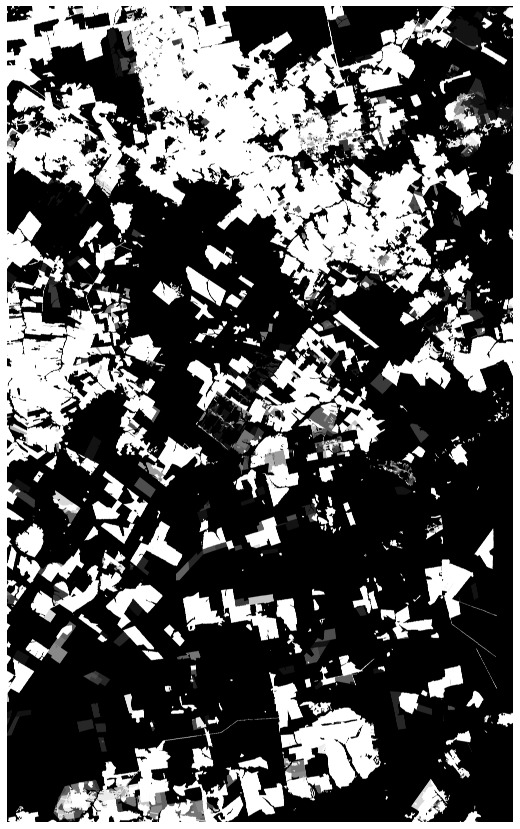

In [15]:


plt.figure(figsize=(15,15))
plt.imshow(image_stack[...,0], cmap=plt.cm.gray)

# title_name = 'ResUnet'
plt.axis('off')
# plt.savefig('figures/Para' + title_name + ' error mask.png', dpi=150, bbox_inches='tight')

In [16]:
ic(image_stack.shape)
channels = image_stack.shape[-1]
ic(channels)

ic| image_stack.shape: (16795, 10420, 21)
ic| channels: 21


21

In [17]:
mask_tr_val, mask_amazon_ts = dataset.getTrainValTestMasks(mask_tiles)


Training tiles:  [2, 4, 5, 6, 7, 12, 14, 15, 18, 21, 23, 24]
Validation tiles:  [9, 11, 25]
Test tiles:  [1, 3, 8, 10, 13, 16, 17, 19, 20, 22]


In [18]:

patch_size = 128
if training == True:

    # Extracting patches from the idx matrix
    overlap = 0.7
    batch_size = 32
    im_idx = patchesHandler.create_idx_image(label_mask)


ic| im_idx_row.shape: (16795, 10420, 1)
    im_idx_col.shape: (16795, 10420, 1)
ic| im_idx_row.dtype: dtype('uint16')
    im_idx_col.dtype: dtype('uint16')
ic| im_idx.shape: (16795, 10420, 2), im_idx.dtype: dtype('uint16')


In [19]:
import importlib
if training == True:
	coords = patchesHandler.extract_patches(
		im_idx, patch_size=(patch_size, patch_size, 2), 
		overlap=overlap)

	coords_train, coords_val = patchesHandler.trainTestSplit(coords,
		mask_tr_val, patch_size=(patch_size, patch_size, 2))

	ic(coords_train.shape, coords_val.shape)
	# del im_idx

ic| coords.shape: (439, 271, 1, 128, 128, 2)
    coords.dtype: dtype('uint16')
ic| coords.shape: (118969, 2), coords.dtype: dtype('uint16')
ic| coords_train.shape: (54516, 3), coords_val.shape: (13175, 3)


In [20]:
label_mask.shape

(16795, 10420, 1)

(-0.5, 10419.5, 16794.5, -0.5)

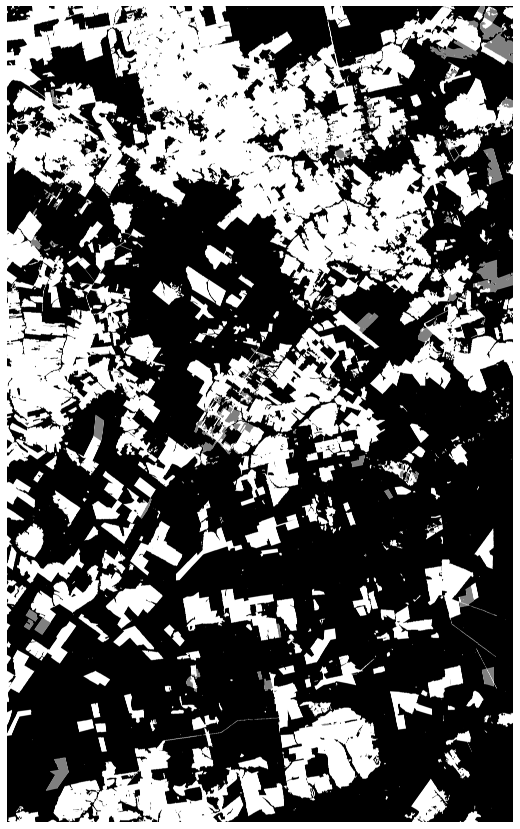

In [21]:

plt.figure(figsize=(15,15))
if type(dataset) != ParaDeforestationTime and type(dataset) != MTDeforestationTime:
    plt.imshow(label_mask[...,-1], cmap=plt.cm.gray)
else:
    plt.imshow(label_mask, cmap=plt.cm.gray)

# title_name = 'ResUnet'
plt.axis('off')
# plt.savefig('figures/Para' + title_name + ' error mask.png', dpi=150, bbox_inches='tight')

In [22]:
np.unique(label_mask)

array([0, 1, 2], dtype=uint8)

In [23]:
if training == True:
    print(coords_train)

[[    0  2090     0]
 [    0  2128     0]
 [    0  2166     0]
 ...
 [16644  8132     0]
 [16644  8170     0]
 [16644  8208     0]]


In [24]:
if training == True:

    # Keeping patches with 2% of def class
    coords_train = patchesHandler.retrieve_idx_percentage(label_mask, coords_train, 
			patch_size, pertentage = 0.2)
    coords_val = patchesHandler.retrieve_idx_percentage(label_mask, coords_val, 
			patch_size, pertentage = 0.2)
    print('training samples: ', coords_train.shape, 
			'validation samples: ', coords_val.shape)


training samples:  (3403, 3) validation samples:  (610, 3)


In [25]:
'''
import src.patchesHandler as sp
importlib.reload(sp)

patchesHandler = sp.PatchesHandlerMultipleDates(
		dataset)
'''

'\nimport src.patchesHandler as sp\nimportlib.reload(sp)\n\npatchesHandler = sp.PatchesHandlerMultipleDates(\n\t\tdataset)\n'

In [26]:
import src.plot as _plt
importlib.reload(_plt)

<module 'src.plot' from 'd:\\Jorge\\deforestation_uncertainty\\src\\plot.py'>

In [27]:
'''
if training == True:
    idx = 3100
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[4,5,6]]), np.mean(image_patch[...,[14,15,16]]))
    _plt.plotCropSample5(image_stack[...,[4,5,6]], image_stack[...,[14,15,16]], 
            image_stack[...,[24,25,26]], image_stack[...,[34,35,36]],
            image_stack[...,[44,45,46]],            
            lims = None, 
            titles = ['2015', '2016', '2017', '2018', '2019'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False, False],
            invertMask = [False, False, False, False, False])
'''

"\nif training == True:\n    idx = 3100\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[4,5,6]]), np.mean(image_patch[...,[14,15,16]]))\n    _plt.plotCropSample5(image_stack[...,[4,5,6]], image_stack[...,[14,15,16]], \n            image_stack[...,[24,25,26]], image_stack[...,[34,35,36]],\n            image_stack[...,[44,45,46]],            \n            lims = None, \n            titles = ['2015', '2016', '2017', '2018', '2019'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False, False],\n            invertMask = [False, False, False, False, False])\n"

In [28]:
inputSnipShow = False

In [29]:
if training == True and inputSnipShow == True:
    idx = 2800
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [30]:
'''
if training == True:

    idx = 6000
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])
'''

"\nif training == True:\n\n    idx = 6000\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))\n    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], \n            reference_patch, reference_patch,\n            lims = None, \n            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False],\n            invertMask = [False, False, False, False])\n"

In [31]:
if training == True and inputSnipShow == True:

    idx = 97
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [32]:
if training == True and inputSnipShow == True:

    idx = 1200
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [33]:
inputSnipShow = False
if training == True and inputSnipShow == True:

    idx = 400
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [34]:
'''
if training == True:

    idx = 6000
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])
'''

"\nif training == True:\n\n    idx = 6000\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))\n    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], \n            reference_patch, reference_patch,\n            lims = None, \n            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False],\n            invertMask = [False, False, False, False])\n"

In [35]:
# Creating train and validation data generator
# importlib.reload(patchesHandler)
import pdb
if training == True:

	train_datagen = ImageDataGenerator()
	valid_datagen = ImageDataGenerator()
	# pdb.set_trace()
	len_X_train = coords_train.shape[0]
	len_X_valid = coords_val.shape[0]

	train_gen = train_datagen.flow(
			np.expand_dims(np.expand_dims(coords_train, axis = -1), axis = -1), 
			np.expand_dims(np.expand_dims(coords_train, axis = -1), axis = -1),
			batch_size=batch_size,
			shuffle=True)
	# pdb.set_trace()

	valid_gen = valid_datagen.flow(
			np.expand_dims(np.expand_dims(coords_val, axis = -1), axis = -1), 
			np.expand_dims(np.expand_dims(coords_val, axis = -1), axis = -1),
			batch_size=batch_size,
			shuffle=False)

	number_class = 3
	train_gen_batch = patchesHandler.batch_generator(train_gen,
			image_stack, label_mask, patch_size, number_class)
	valid_gen_batch = patchesHandler.batch_generator(valid_gen,
			image_stack, label_mask, patch_size, number_class)

	#del image_stack

In [36]:
# Creating folder for the experiment

path_exp = dataset.paths.experiment + 'exp' + str(exp)
path_models = path_exp+'/models'
path_maps = path_exp+'/pred_maps'

if not os.path.exists(path_exp):
    os.makedirs(path_exp)   
if not os.path.exists(path_models):
    os.makedirs(path_models)   
if not os.path.exists(path_maps):
    os.makedirs(path_maps)
    
times = 1
method = 'resunet'
nb_filters = [16, 32, 64, 128, 256]
weights = [0.1, 0.9, 0]

In [37]:
if type(patchesHandler) == PatchesHandlerMultipleDates:
	channels = patchesHandler.input_image_shape

In [38]:
path_exp

'D:/Jorge/datasets/deforestation/experiments/MT/exp112'

In [39]:
channels

21

In [40]:
image_stack.shape

(16795, 10420, 21)

In [41]:

metrics_all = []
if training == True:
    for tm in range(0,times):
        print('time: ', tm)

        rows = patch_size
        cols = patch_size
        adam = Adam(lr = 1e-3 , beta_1=0.9)
        
        loss = weighted_categorical_crossentropy(weights)
        input_shape = (rows, cols, channels)
        model = build_resunet_dropout_spatial(input_shape, nb_filters, number_class)
        
        model.compile(optimizer=adam, loss=loss, metrics=['accuracy'])
        model.summary()

        earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min')
        checkpoint = ModelCheckpoint(path_models+ '/' + method +'_'+str(tm)+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        lr_reduce = ReduceLROnPlateau(factor=0.9, min_delta=0.0001, patience=5, verbose=1)
        callbacks_list = [earlystop, checkpoint]
        # train the model
        start_training = time.time()
        history = model.fit_generator(train_gen_batch,
                                steps_per_epoch=len_X_train*3//train_gen.batch_size,
                                validation_data=valid_gen_batch,
                                validation_steps=len_X_valid*3//valid_gen.batch_size,
                                epochs=100,
                                callbacks=callbacks_list)
        end_training = time.time() - start_training
        # metrics_all.append(end_training)
        del model, history

    # Saving training time
    # np.save(path_exp+'/metrics_tr.npy', metrics_all)
    del train_gen_batch, valid_gen_batch

time:  0


c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_enc_net (InputLayer)      [(None, 128, 128, 21 0                                            
__________________________________________________________________________________________________
res1_net1 (Conv2D)              (None, 128, 128, 16) 3040        input_enc_net[0][0]              
__________________________________________________________________________________________________
drop_net1 (SpatialDropout2D)    (None, 128, 128, 16) 0           res1_net1[0][0]                  
__________________________________________________________________________________________________
res2_net1 (Conv2D)              (None, 128, 128, 16) 2320        drop_net1[0][0]                  
______________________________________________________________________________________________

c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\engine\training.py:1969: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


319/319 [==============================] - 34s 90ms/step - loss: 0.0820 - accuracy: 0.8305 - val_loss: 0.0303 - val_accuracy: 0.9421

Epoch 00001: val_loss improved from inf to 0.03034, saving model to D:/Jorge/datasets/deforestation/experiments/MT/exp112/models\resunet_0.h5
Epoch 2/100
  1/319 [..............................] - ETA: 20s - loss: 0.0890 - accuracy: 0.8555

c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


319/319 [==============================] - 27s 86ms/step - loss: 0.0621 - accuracy: 0.8898 - val_loss: 0.0232 - val_accuracy: 0.9531

Epoch 00002: val_loss improved from 0.03034 to 0.02324, saving model to D:/Jorge/datasets/deforestation/experiments/MT/exp112/models\resunet_0.h5
Epoch 3/100
319/319 [==============================] - 27s 86ms/step - loss: 0.0560 - accuracy: 0.9012 - val_loss: 0.0206 - val_accuracy: 0.9568

Epoch 00003: val_loss improved from 0.02324 to 0.02059, saving model to D:/Jorge/datasets/deforestation/experiments/MT/exp112/models\resunet_0.h5
Epoch 4/100
319/319 [==============================] - 27s 86ms/step - loss: 0.0515 - accuracy: 0.9078 - val_loss: 0.0194 - val_accuracy: 0.9586

Epoch 00004: val_loss improved from 0.02059 to 0.01944, saving model to D:/Jorge/datasets/deforestation/experiments/MT/exp112/models\resunet_0.h5
Epoch 5/100
319/319 [==============================] - 27s 86ms/step - loss: 0.0513 - accuracy: 0.9072 - val_loss: 0.0188 - val_accuracy

In [42]:
image_stack.shape

(16795, 10420, 21)

In [43]:
if type(dataset) != ParaDeforestationTime and type(dataset) != MTDeforestationTime:
    patchesHandler.dataset.image_channels[-1]

In [44]:
if type(dataset) == ParaMultipleDates:
	channels = patchesHandler.input_image_shape
	image_stack = image_stack[..., patchesHandler.dataset.image_channels[-1]]
	label_mask = label_mask[...,-1]

In [45]:
image_stack.shape

(16795, 10420, 21)

In [46]:
#%% Test loop

metrics_ts = []
n_pool = 3
n_rows = 5
n_cols = 4
rows, cols = image_stack.shape[:2]
pad_rows = rows - np.ceil(rows/(n_rows*2**n_pool))*n_rows*2**n_pool
pad_cols = cols - np.ceil(cols/(n_cols*2**n_pool))*n_cols*2**n_pool
print(pad_rows, pad_cols)

npad = ((0, int(abs(pad_rows))), (0, int(abs(pad_cols))), (0, 0))
image1_pad = np.pad(image_stack, pad_width=npad, mode='reflect')
# del image_stack


-5.0 -12.0


In [47]:

h, w, c = image1_pad.shape
c = channels
patch_size_rows = h//n_rows
patch_size_cols = w//n_cols
num_patches_x = int(h/patch_size_rows)
num_patches_y = int(w/patch_size_cols)

ic(path_models+ '/' + method +'_'+str(0)+'.h5')
model = load_model(path_models+ '/' + method +'_'+str(0)+'.h5', compile=False)
class_n = 3

if loadInference == False:
    if save_probabilities == False:
        # prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], class_n, inference_times), dtype = np.float32)
        prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], inference_times), dtype = np.float32)

    new_model = utils_v1.build_resunet_dropout_spatial(input_shape=(patch_size_rows,patch_size_cols, c), 
        nb_filters = nb_filters, n_classes = class_n, dropout_seed = None)

    for l in range(1, len(model.layers)):
        new_model.layers[l].set_weights(model.layers[l].get_weights())
    
            

    metrics_all =[]
    with tf.device('/cpu:0'):
        for tm in range(0,inference_times):
            print('time: ', tm)

            
            # Recinstructing predicted map
            start_test = time.time()
            '''
            args_network = {'patch_size_rows': patch_size_rows,
                'patch_size_cols': patch_size_cols,
                'c': c,
                'nb_filters': nb_filters,
                'class_n': class_n,
                'dropout_seed': inference_times}
            '''
            prob_reconstructed = patchesHandler.infer(
                    new_model, image1_pad, h, w, 
                    # model, image1_pad, h, w, 
                    num_patches_x, num_patches_y, patch_size_rows, 
                    patch_size_cols)
                    # patch_size_cols, a = args_network)
                    
            ts_time =  time.time() - start_test

            if save_probabilities == True:
                np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_reconstructed) 
            else:
                prob_rec[:,:,tm] = prob_reconstructed
            
            metrics_all.append(ts_time)
            del prob_reconstructed
        metrics_ = np.asarray(metrics_all)
        # Saving test time
        np.save(path_exp+'/metrics_ts.npy', metrics_)


ic| path_models+ '/' + method +'_'+str(0)+'.h5': 'D:/Jorge/datasets/deforestation/experiments/MT/exp112/models/resunet_0.h5'


time:  0
time:  1
time:  2
time:  3
time:  4
time:  5
time:  6
time:  7
time:  8
time:  9


In [48]:
'''
with tf.device('/cpu:0'):
    for tm in range(0,times):
        np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_rec[:,:,tm]) 
'''

"\nwith tf.device('/cpu:0'):\n    for tm in range(0,times):\n        np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_rec[:,:,tm]) \n"

In [49]:
del image1_pad


In [50]:
# if loadInference == True:
if save_probabilities == True:
    prob_rec = np.zeros((h, w, inference_times), dtype = np.float32)

    for tm in range(0, inference_times):
        print(tm)
        prob_rec[:,:,tm] = np.load(path_maps+'/'+'prob_'+str(tm)+'.npy').astype(np.float32)




In [51]:
useLessInferenceRuns = False
if useLessInferenceRuns == True:

    reducedInferenceRuns = 3
    # prob_rec_all = prob_rec.copy()
    prob_rec = prob_rec_all[:reducedInferenceRuns]
    prob_rec = np.transpose(np.squeeze(prob_rec), (1, 2, 0))


In [52]:
prob_rec.shape

(16800, 10432, 10)

In [53]:
prob_rec.shape

(16800, 10432, 10)

In [54]:
mean_prob = np.mean(prob_rec, axis = -1)
# np.save(path_maps+'/prob_mean.npy', mean_prob)


In [55]:
ic(np.min(mean_prob), np.mean(mean_prob), np.max(mean_prob))

ic| np.min(mean_prob): 3.5276403e-32
    np.mean(mean_prob): 0.014819855
    np.max(mean_prob): 1.0


(3.5276403e-32, 0.014819855, 1.0)

In [56]:
ic(mean_prob.shape)

ic| mean_prob.shape: (16800, 10432)


(16800, 10432)

In [57]:
# Computing metrics over the test tiles
mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
'''
ref1 = np.ones_like(label_mask).astype(np.float32)

ref1 [label_mask == 2] = 0
TileMask = mask_amazon_ts * ref1
GTTruePositives = label_mask==1
'''


'\nref1 = np.ones_like(label_mask).astype(np.float32)\n\nref1 [label_mask == 2] = 0\nTileMask = mask_amazon_ts * ref1\nGTTruePositives = label_mask==1\n'

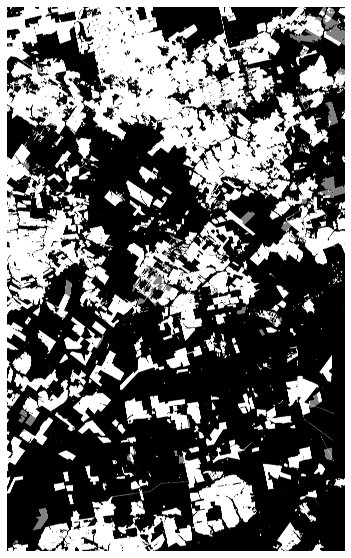

In [58]:
fig1 = plt.figure(figsize=(10,10))
plt.imshow(label_mask, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [59]:
if issubclass(type(dataset), MultipleDates):
    label_mask = np.squeeze(label_mask)

In [60]:
mean_prob.shape

(16795, 10420)

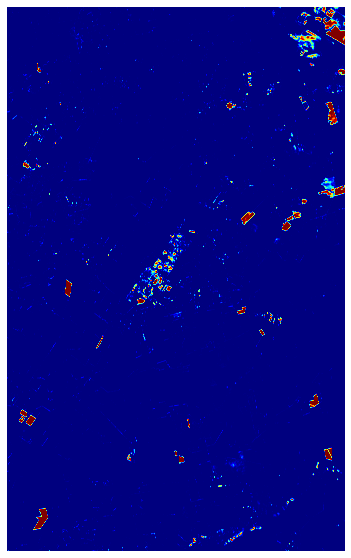

In [61]:
mean_prob = mean_prob.copy()
mean_prob[label_mask == 2] = 0
fig1 = plt.figure(figsize=(10,10))
plt.imshow(mean_prob, cmap = 'jet')
plt.axis('off')
plt.savefig('figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [62]:
# print(np.unique(label_mask, return_counts=True))
print(label_mask.shape)

(16795, 10420)


In [63]:
label_test = label_mask[mask_amazon_ts == 1]
mean_prob_test = mean_prob[mask_amazon_ts == 1]
mean_prob_test = mean_prob_test[label_test != 2]
label_test = label_test[label_test != 2]

print(label_test.shape)
print(np.unique(label_test, return_counts=True))

(44657480,)
(array([0, 1], dtype=uint8), array([43783238,   874242], dtype=int64))


In [64]:
from sklearn import metrics
mAP = round(metrics.average_precision_score(label_test, 
        mean_prob_test)*100, 2)
print(mAP)

81.05


In [65]:
from icecream import ic

ic(prob_rec.shape)
prob_rec = np.transpose(prob_rec, (2, 0, 1))


ic| prob_rec.shape: (16800, 10432, 10)


In [66]:
prob_rec = np.expand_dims(prob_rec, axis = -1)

In [67]:
ic(prob_rec.shape)

ic| prob_rec.shape: (10, 16800, 10432, 1)


(10, 16800, 10432, 1)

In [68]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

epsilon = 1e-15
def show_im(im, ax, title = "", cmap = "jet"):
    im_plt = ax.imshow(im.astype(np.float32), cmap = cmap)
    plt.title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im_plt, cax=cax) 

def get_mean(pred_probs):
      return np.mean(pred_probs, axis=0)
    
def get_uncertainty_var(pred_probs):
    return np.var(pred_probs, axis=0)
    
def predictive_variance(pred_probs):
    pred_var = get_uncertainty_var(pred_probs)
    pred_var = np.average(pred_var, axis = -1)
#    ic(pred_var.shape)
    return pred_var

def predictive_entropy(pred_probs):
    pred_mean = get_mean(pred_probs) # shape (patch_len, patch_len, class_n)
    pred_entropy = np.zeros((pred_mean.shape[0:2]))

    K = pred_mean.shape[-1]
    for k in range(K):
        pred_entropy = pred_entropy + pred_mean[..., k] * np.log(pred_mean[..., k] + epsilon) 
    pred_entropy = - pred_entropy / K
    return pred_entropy


def single_experiment_entropy(pred_prob):
    pred_entropy = np.zeros(pred_prob.shape[0:2])
    ic(pred_entropy.shape)
    
    K = pred_prob.shape[-1]
    for k in range(K):
        pred_entropy = pred_entropy + pred_prob[..., k] * np.log(pred_prob[..., k] + epsilon) 
    pred_entropy = - pred_entropy / K
    return pred_entropy

def mutual_information(pred_probs):
    H = predictive_entropy(pred_probs)
    
    # sum_entropy = 0
    sum_entropy = np.zeros(pred_probs.shape[1:-1])

    n = pred_probs.shape[0]
    K = pred_probs.shape[-1]
    ic(n, K)

    for i in range(n):
        for k in range(K):
            sum_entropy = sum_entropy + pred_probs[i, ..., k] * np.log(pred_probs[i, ..., k] + epsilon)

    sum_entropy = - sum_entropy / (n * K)

    MI = H - sum_entropy
    return MI


def expected_KL_divergence(pred_probs):
    pred_mean = get_mean(pred_probs) # shape (patch_len, patch_len, class_n)
    KL_divergence = np.zeros(pred_mean.shape[0:2])

    n = pred_probs.shape[0]
    K = pred_probs.shape[-1]

    for i in range(n):
        for k in range(K):
            # print(np.mean(pred_mean[..., k]), np.mean(pred_probs[i, ..., k]), np.mean(KL_divergence))
            # pdb.set_trace()
            KL_divergence += pred_mean[..., k] * np.log(pred_mean[..., k] / (pred_probs[i, ..., k] + epsilon) + epsilon)
    KL_divergence /= n
    return KL_divergence


In [69]:
ic(np.min(prob_rec), np.mean(prob_rec), np.max(prob_rec))
ic(prob_rec.shape)

ic| np.min(prob_rec): 0.0
    np.mean(prob_rec): 0.014814973
    np.max(prob_rec): 1.0
ic| prob_rec.shape: (10, 16800, 10432, 1)


(10, 16800, 10432, 1)

In [70]:
pred_entropy = predictive_entropy(prob_rec).astype(np.float32)

pred_entropy_single = single_experiment_entropy(prob_rec[0]).astype(np.float32)

pred_var = predictive_variance(prob_rec).astype(np.float32)

MI = mutual_information(prob_rec).astype(np.float32)



ic| pred_entropy.shape: (16800, 10432)
ic| n: 10, K: 1


In [71]:
KL = expected_KL_divergence(prob_rec).astype(np.float32)

In [72]:
np.mean(KL)

0.0038628443

In [73]:

pred_entropy_to_show = pred_entropy.copy()[:label_mask.shape[0], :label_mask.shape[1]]

pred_entropy_to_show[label_mask == 2] = 0


In [74]:
ic(np.min(pred_entropy_to_show), np.mean(pred_entropy_to_show), np.max(pred_entropy_to_show))
ic(np.min(pred_entropy), np.mean(pred_entropy), np.max(pred_entropy))
ic(pred_entropy.shape, pred_entropy_to_show.shape)

ic| np.min(pred_entropy_to_show): 0.0
    np.mean(pred_entropy_to_show): 0.0066105393
    np.max(pred_entropy_to_show): 0.36787948
ic| np.min(pred_entropy): -0.0
    np.mean(pred_entropy): 0.0073958114
    np.max(pred_entropy): 0.36787948
ic| pred_entropy.shape: (16800, 10432)
    pred_entropy_to_show.shape: (16795, 10420)


((16800, 10432), (16795, 10420))

In [75]:
prob_rec.shape

(10, 16800, 10432, 1)

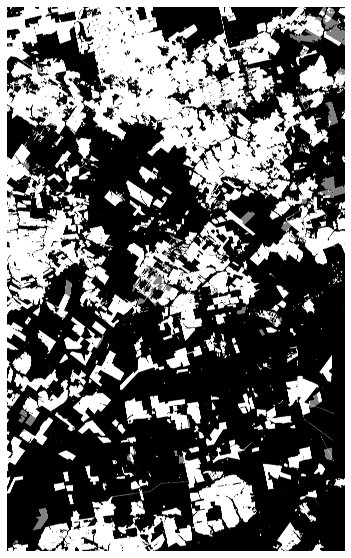

In [76]:
fig1 = plt.figure(figsize=(10,10))
plt.imshow(label_mask, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [77]:
# Computing error mask
# label_mask
'''
for idx in range(10):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(prob_rec[idx], cmap = 'jet')
# fig.savefig('figures/Para' + title_name + ' reference.png', dpi=300, bbox_inches='tight')
'''

"\nfor idx in range(10):\n    fig, ax = plt.subplots(figsize=(10,10))\n    ax.set_xticks([])\n    ax.set_yticks([])\n    ax.imshow(prob_rec[idx], cmap = 'jet')\n# fig.savefig('figures/Para' + title_name + ' reference.png', dpi=300, bbox_inches='tight')\n"

(-0.5, 10419.5, 16794.5, -0.5)

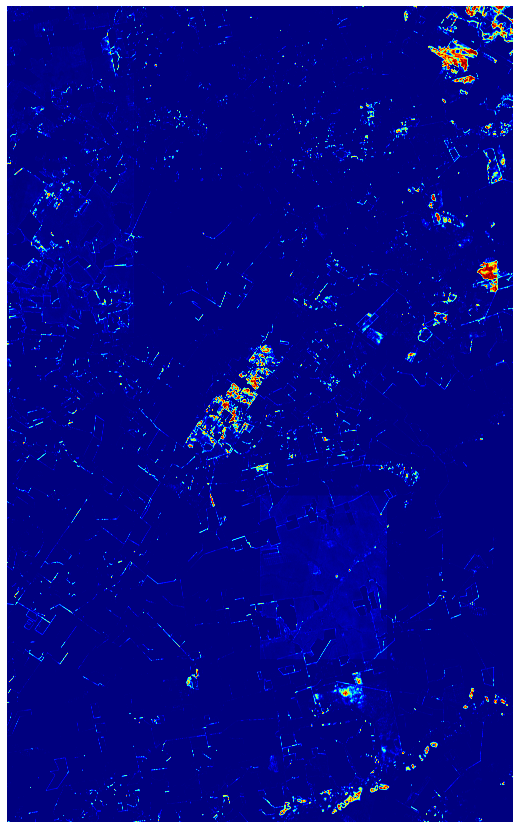

In [78]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(pred_entropy_to_show, cmap='jet')
# show_im(pred_entropy_to_show, ax, title = 'Uncertainty predictive entropy')
plt.axis('off')
#plt.savefig('figures/Para' + title_name + ' uncertainty predictive entropy.png', 
 #   dpi=150, bbox_inches='tight')

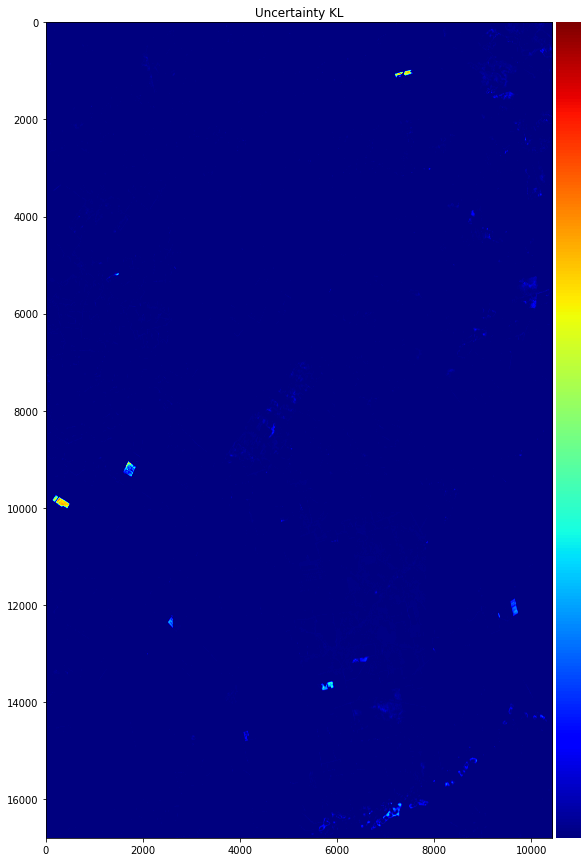

In [79]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
show_im(KL, ax, title = 'Uncertainty KL')
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' uncertainty KL.png', 
    dpi=150, bbox_inches='tight')

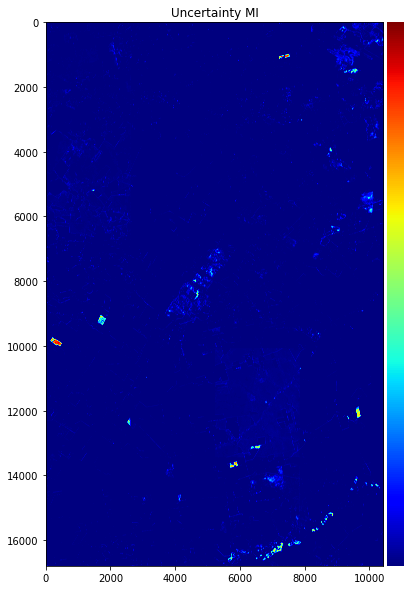

In [80]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(MI, ax, title = 'Uncertainty MI')
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' uncertainty MI.png', 
    dpi=150, bbox_inches='tight')

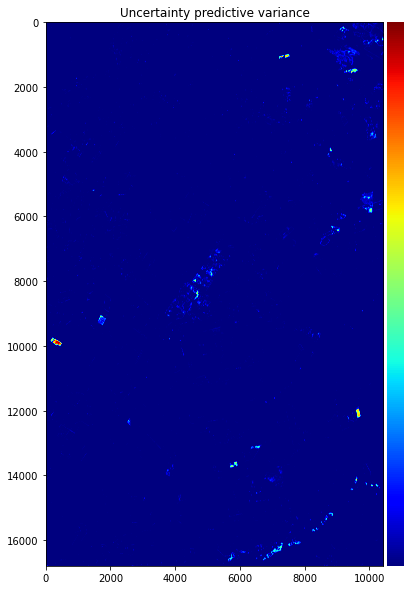

In [81]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_var, ax, title = 'Uncertainty predictive variance')
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' uncertainty Predictive variance.png', 
    dpi=150, bbox_inches='tight')

In [82]:
ic(pred_entropy.shape)


ic| pred_entropy.shape: (16800, 10432)


(16800, 10432)

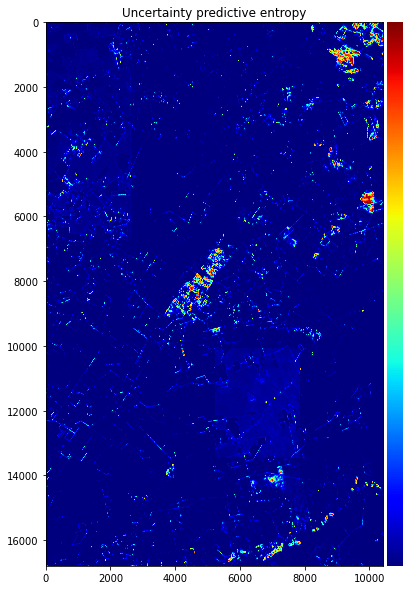

In [83]:

# pred_entropy_to_show = pred_entropy[:label_mask.shape[0], :label_mask.shape[1]].copy()

# ic(np.min(pred_entropy_to_show), np.mean(pred_entropy_to_show), np.max(pred_entropy_to_show))

# pred_entropy_to_show[label_mask == 2] = 0
fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_entropy_to_show, ax, title = 'Uncertainty predictive entropy')
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' uncertainty predictive entropy.png', 
    dpi=150, bbox_inches='tight')

In [84]:
ic(prob_rec.shape)
ic(np.min(prob_rec), np.mean(prob_rec), np.max(prob_rec))


ic| prob_rec.shape: (10, 16800, 10432, 1)
ic| np.min(prob_rec): 0.0
    np.mean(prob_rec): 0.014814973
    np.max(prob_rec): 1.0


(0.0, 0.014814973, 1.0)

In [85]:


'''
fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_entropy_single, ax, title = 'Uncertainty predictive entropy single sample')
'''


"\nfig, ax = plt.subplots(1,1,figsize=(10,10))\nshow_im(pred_entropy_single, ax, title = 'Uncertainty predictive entropy single sample')\n"

In [86]:

'''
MI = mutual_information(prob_rec)

fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(MI, ax, title = 'Uncertainty MI')
'''


"\nMI = mutual_information(prob_rec)\n\nfig, ax = plt.subplots(1,1,figsize=(10,10))\nshow_im(MI, ax, title = 'Uncertainty MI')\n"

(array([0, 1, 2], dtype=uint8), array([70001560, 84001872, 21000468], dtype=int64))


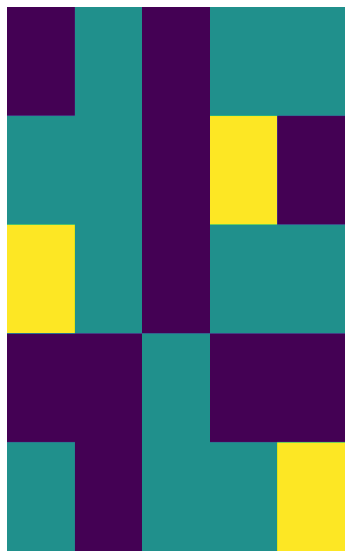

In [87]:
# mask_tr_val = test 0, train 1, val 2. 
# mask_ts = test 1.
print(np.unique(mask_tr_val, return_counts=True))
plt.figure(figsize=(10,10))
plt.imshow(mask_tr_val)
plt.axis('off')
plt.savefig('figures/Train val mask.png', dpi=200, bbox_inches='tight')



In [88]:
label_mask_current_deforestation = label_mask.copy()
label_mask_current_deforestation[label_mask_current_deforestation==2] = 0

In [89]:
label_mask_current_deforestation_to_show = label_mask_current_deforestation.copy()
label_mask_current_deforestation_to_show = np.abs(
        label_mask_current_deforestation_to_show - 1)
ic(np.unique(label_mask_current_deforestation_to_show, return_counts=True))

ic| np.unique(label_mask_current_deforestation_to_show, return_counts=True): (array([  0, 255], dtype=uint8), array([  2271496, 172732404], dtype=int64))


(array([  0, 255], dtype=uint8), array([  2271496, 172732404], dtype=int64))

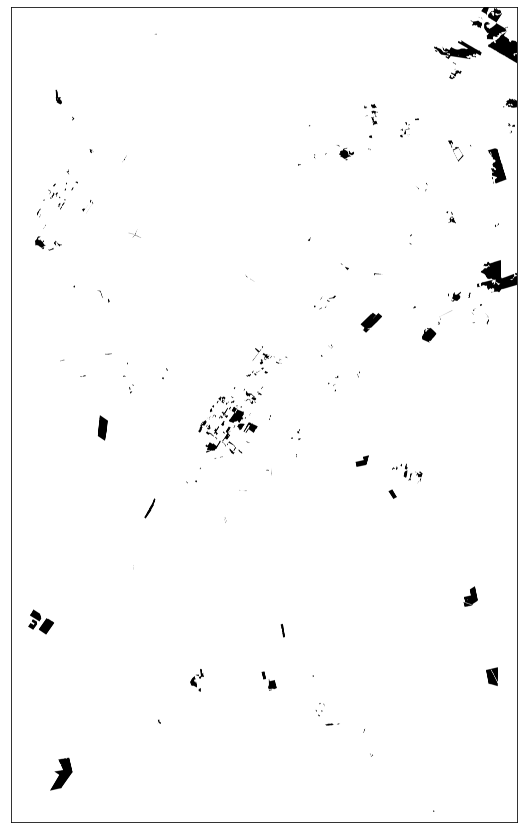

In [90]:
# Computing error mask
# label_mask

fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(label_mask_current_deforestation_to_show, cmap = plt.cm.gray)
fig.savefig('figures/Para' + title_name + ' reference.png', dpi=300, bbox_inches='tight')




In [91]:


label_mask_val = label_mask[mask_tr_val == 2]
ic(label_mask_val.shape)

mean_prob_val = mean_prob[mask_tr_val == 2]

mean_prob_val = mean_prob_val[label_mask_val != 2]
label_mask_val_valid = label_mask_val[label_mask_val != 2]
ic(label_mask_val_valid.shape)



ic| label_mask_val.shape: (21000468,)
ic| label_mask_val_valid.shape: (11806421,)


(11806421,)

In [92]:
from sklearn import metrics
pos_label = 1
precision, recall, thresholds = metrics.precision_recall_curve(
            label_mask_val_valid, mean_prob_val, pos_label=pos_label)



In [93]:
fscore = (2 * precision * recall) / (precision + recall)
ix = np.nanargmax(fscore)
best_threshold = thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.726928, F-Score=0.954


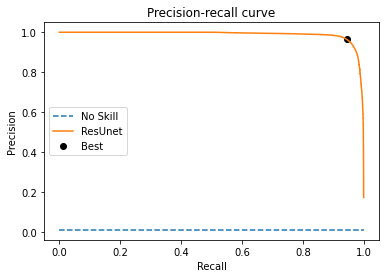

In [94]:
importlib.reload(_metrics)
_metrics.plotPrecisionRecall(label_mask_val, precision, recall, ix)
plt.savefig('figures/' + 'Para_prediction_recall_curve.png', dpi=150, bbox_inches='tight')

In [95]:
print(mean_prob.shape)
predicted = np.zeros_like(mean_prob)
threshold = 0.5
# threshold = 0.698

predicted[mean_prob>=threshold] = 1
predicted[mean_prob<threshold] = 0
# predicted[prob_rec[0][...,-1][:label_mask.shape[0], :label_mask.shape[1]]>=threshold] = 1
# predicted[prob_rec[0][...,-1][:label_mask.shape[0], :label_mask.shape[1]]<threshold] = 0

print(np.unique(predicted, return_counts=True))

predicted_unpad = predicted.copy()
predicted_unpad[label_mask == 2] = 0
ic(predicted_unpad.shape, predicted.shape)
del predicted

(16795, 10420)
(array([0., 1.], dtype=float32), array([172809359,   2194541], dtype=int64))


ic| predicted_unpad.shape: (16795, 10420)
    predicted.shape: (16795, 10420)


In [96]:
threshold

0.5

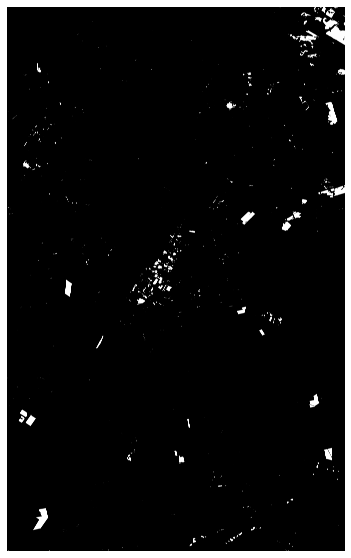

In [97]:

plt.figure(figsize=(10,10))
plt.imshow(predicted_unpad, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' predicted.png', dpi=150, bbox_inches='tight')


In [98]:

# mean_prob_unpad = mean_prob[:-npad[0][1], :-npad[1][1]]

In [99]:
# mean_prob_unpad.shape

In [100]:
# ic(mask_amazon_ts.shape)
# mask_amazon_ts = mask_amazon_ts[:-npad[0][1], :-npad[1][1]]


In [101]:
# ic(mask_amazon_ts.shape, predicted_unpad.shape)
# label_mask_current_deforestation = label_mask_current_deforestation[:-npad[0][1], :-npad[1][1]]

In [102]:
# label_mask = label_mask[:-npad[0][1], :-npad[1][1]]

In [103]:
import importlib
import utils_v1
importlib.reload(utils_v1)

<module 'utils_v1' from 'd:\\Jorge\\deforestation_uncertainty\\utils_v1.py'>

In [104]:
ic(predicted_unpad.shape, label_mask_current_deforestation.shape,
    mask_amazon_ts.shape, label_mask.shape, mean_prob.shape)

ic| predicted_unpad.shape: (16795, 10420)
    label_mask_current_deforestation.shape: (16795, 10420)
    mask_amazon_ts.shape: (16795, 10420)
    label_mask.shape: (16795, 10420)
    mean_prob.shape: (16795, 10420)


((16795, 10420),
 (16795, 10420),
 (16795, 10420),
 (16795, 10420),
 (16795, 10420))

In [105]:
# test metrics
from sklearn.metrics import f1_score

predicted_test = predicted_unpad[mask_amazon_ts == 1]
label_mask_current_deforestation_test = label_mask_current_deforestation[mask_amazon_ts == 1]
label_mask_test = label_mask[mask_amazon_ts == 1]
mean_prob_test = mean_prob[mask_amazon_ts == 1]

ic(predicted_test.shape)

predicted_test = utils_v1.excludeBackgroundAreasFromTest(
        predicted_test, label_mask_test)
label_mask_current_deforestation_test = utils_v1.excludeBackgroundAreasFromTest(
        label_mask_current_deforestation_test, label_mask_test)
mean_prob_test = utils_v1.excludeBackgroundAreasFromTest(
        mean_prob_test, label_mask_test)

ic(predicted_test.shape)


ic| predicted_test.shape: (70001560,)
ic| predicted_test.shape: (44657480,)


(44657480,)

In [106]:
importlib.reload(_metrics)
removePolygons = True
if removePolygons == True:
    # remove polygons smaller than 625 px
    min_polygon_area = 625 # pixels

    predicted_unpad, label_mask = _metrics.removeSmallPolygonsForMetrics(predicted_unpad, label_mask,
        min_polygon_area)
    predicted_masked, label_masked = _metrics.getTest(predicted_unpad, label_mask, mask_amazon_ts)

    predicted_test = predicted_masked
    label_mask_current_deforestation_test = label_masked


ic| np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([172809359,   2194541], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([172914867,   2089033], dtype=int64))
ic| np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([174898392,    105508], dtype=int64))
ic| predicted.shape: (16795, 10420), label_mask.shape: (16795, 10420)
ic| predicted_masked.shape: (70001560,)
    label_masked.shape: (70001560,)
ic| np.unique(label_masked, return_counts=True): (array([0, 1, 2], dtype=uint8),
                                                  array([43761422,   854795, 25385343], dtype=int64))
ic| predicted_masked.shape: (44616217,)
    label_masked.shape: (44616217,)


In [107]:

deforestationMetricsGet = True
if deforestationMetricsGet == True:
        f1 = round(f1_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        precision = round(precision_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        recall = round(recall_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        if removePolygons == False:
                mAP = round(metrics.average_precision_score(label_mask_current_deforestation_test, 
                        mean_prob_test)*100, 2)
        else:
                '''
                # Computing metrics over the test tiles
                # mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
                ref1 = np.ones_like(label_mask).astype(np.float32)

                ref1 [label_mask == 2] = 0
                TileMask = mask_amazon_ts * ref1
                GTTruePositives = label_mask==1

                # Metrics for th=0.5    

                Npoints = 50
                Pmax = np.max(mean_prob[GTTruePositives * TileMask ==1])
                ProbList = np.linspace(Pmax,0,Npoints)

                metrics_ = matrics_AA_recall(ProbList, mean_prob, label_mask, mask_amazon_ts, 625)
                print('Metrics th = 0.5: ', metrics_*100)
                '''
                pass


In [108]:
ic(f1, precision, recall)
# ic(f1, precision, recall)


ic| f1: 73.37, precision: 80.26, recall: 67.57


(73.37, 80.26, 67.57)

### Metrics for validation set in forest/deforestation detection

In [109]:
ic(mask_tr_val.shape)

ic| mask_tr_val.shape: (16795, 10420)


(16795, 10420)

In [110]:
predicted_val = predicted_unpad[mask_tr_val == 2]
predicted_val = predicted_val[label_mask_val != 2]

In [111]:

f1_val = round(f1_score(label_mask_val_valid, predicted_val)*100, 2)
precision_val = round(precision_score(label_mask_val_valid, predicted_val)*100, 2)
recall_val = round(recall_score(label_mask_val_valid, predicted_val)*100, 2)

mAP_val = round(metrics.average_precision_score(label_mask_val_valid, mean_prob_val)*100, 2)


ic(f1_val, precision_val, recall_val, mAP_val)

ic| f1_val: 94.18
    precision_val: 93.06
    recall_val: 95.32
    mAP_val: 98.9


(94.18, 93.06, 95.32, 98.9)

In [112]:
calculateMAPWithoutSmallPolygons = False
if calculateMAPWithoutSmallPolygons == True:
    # Computing metrics over the test tiles
    # mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
    ref1 = np.ones_like(label_mask).astype(np.uint8)

    ref1 [label_mask == 2] = 0
    TileMask = mask_amazon_ts * ref1
    GTTruePositives = label_mask==1

    # Metrics for th=0.5    

    ProbList_05 = [0.5]

    metrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)
    print('Metrics th = 0.5: ', metrics_05*100)


In [113]:

error_mask = np.abs(predicted_unpad - label_mask_current_deforestation)
print(np.unique(error_mask, return_counts=True))


(array([0., 1.], dtype=float32), array([174259089,    744811], dtype=int64))


In [114]:
false_positive_mask = predicted_unpad - label_mask_current_deforestation
ic(false_positive_mask.shape)
ic(np.unique(false_positive_mask, return_counts=True))
# 0 class 0, 1 class 1, 2 false positive, 3 false negative
# colormap black, white, blue, red.



ic| false_positive_mask.shape: (16795, 10420)
ic| np.unique(false_positive_mask, return_counts=True): (array([-1.,  0.,  1.], dtype=float32),
                                                         array([   463637, 174259089,    281174], dtype=int64))


(array([-1.,  0.,  1.], dtype=float32),
 array([   463637, 174259089,    281174], dtype=int64))

In [115]:
ic(predicted_unpad.shape, label_mask.shape)

ic| predicted_unpad.shape: (16795, 10420)
    label_mask.shape: (16795, 10420)


((16795, 10420), (16795, 10420))

In [116]:

importlib.reload(_metrics)

prediced_unpad_to_show = predicted_unpad.copy()
prediced_unpad_to_show[label_mask == 2] = 0

error_mask_to_show = _metrics.getRgbErrorMask(prediced_unpad_to_show, 
        label_mask_current_deforestation).astype(np.uint8)
error_mask_to_show_rgb = _metrics.saveRgbErrorMask(error_mask_to_show).astype(np.uint8)
del error_mask_to_show
cv2.imwrite('figures/Para_error_mask_to_show_rgb.png', error_mask_to_show_rgb)

# ,
#        dim = (617, 1162)


True

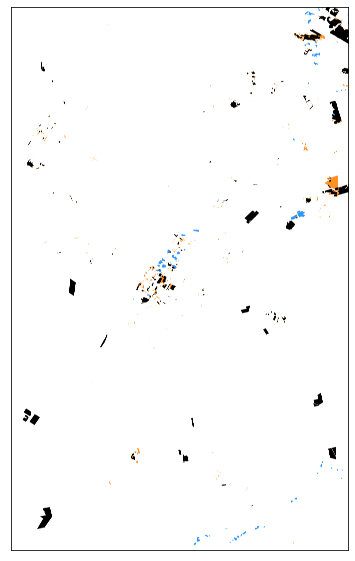

In [117]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xticks([])
ax.set_yticks([])

ax.imshow(error_mask_to_show_rgb[...,::-1])

fig.savefig('figures/Para' + title_name + ' error mask color.png', dpi=300, bbox_inches='tight')


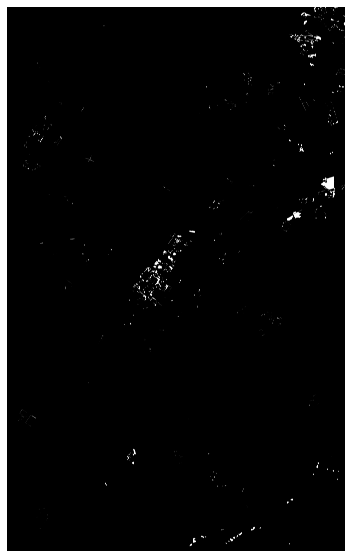

In [118]:
plt.figure(figsize=(10,10))
plt.imshow(error_mask, cmap=plt.cm.gray)
title_name = 'ResUnet'
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' error mask.png', dpi=150, bbox_inches='tight')

In [119]:
ic(label_mask.shape)
ic(mask_amazon_ts.shape)
 
label_mask_test = utils_v1.getTestVectorFromIm(
        label_mask, mask_amazon_ts)        
ic(label_mask_test.shape)

error_mask_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
        error_mask, mask_amazon_ts),
        label_mask_test) 


error_mask_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
        error_mask, mask_tr_val, mask_return_value = 2),
        label_mask_val) 

 
ic(error_mask_test.shape)

ic| label_mask.shape: (16795, 10420)
ic| mask_amazon_ts.shape: (16795, 10420)
ic| label_mask_test.shape: (70001560,)
ic| error_mask_test.shape: (44616217,)


(44616217,)

In [120]:
# ic(pred_entropy[:-npad[0][1], :-npad[1][1]][:-npad[0][1], :-npad[1][1]].shape)

In [121]:
     

ic(pred_entropy.shape, utils_v1.unpadIm(pred_entropy, npad).shape, 
    mask_amazon_ts.shape, label_mask_test.shape)
pred_entropy_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy, npad), mask_amazon_ts),
        label_mask_test)
  
pred_var_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_var, npad), mask_amazon_ts),
        label_mask_test)

MI_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(MI, npad), mask_amazon_ts),
        label_mask_test)

KL_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(KL, npad), mask_amazon_ts),
        label_mask_test)


ic| pred_entropy.shape: (16800, 10432)
    utils_v1.unpadIm(pred_entropy, npad).shape: (16795, 10420)
    mask_amazon_ts.shape: (16795, 10420)
    label_mask_test.shape: (70001560,)


In [122]:
pred_entropy_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy, npad), mask_tr_val, mask_return_value = 2),
        label_mask_val)

pred_var_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_var, npad), mask_tr_val, mask_return_value = 2),
        label_mask_val)

MI_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(MI, npad), mask_tr_val, mask_return_value = 2),
        label_mask_val)

KL_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(KL, npad), mask_tr_val, mask_return_value = 2),
        label_mask_val)


In [123]:
pred_entropy_single_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy_single, npad), mask_amazon_ts),
        label_mask_test)

pred_entropy_single_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy_single, npad), mask_tr_val, mask_return_value = 2),
        label_mask_val)

        

In [124]:
# dataset.previewLims1 = np.array([2200, 3200, 6900, 7900])
# dataset.previewLims2 = np.array([500, 1500, 3500, 4500])
# dataset.previewBands = [2, 1, 0] 

In [125]:


# dataset.previewLims1 = np.array([7600, 8600, 4500, 5500])
# dataset.previewLims1 = np.array([12200, 13200, 200, 1200])
# dataset.previewLims1 = np.array([11800, 12800, 9000, 10000])

# dataset.previewLims1 = np.array([11500, 12500, 9000, 10000])

# dataset.previewLims2 = np.array([5000, 6000, 9500, 10500])

ic(dataset.previewLims1, dataset.previewLims2)
lims = dataset.previewLims1
ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True))
lims = dataset.previewLims2
ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]))
ic(mask_amazon_ts.shape)


ic| dataset.previewLims1: array([11500, 12500,  9000, 10000])
    dataset.previewLims2: array([ 5000,  6000,  9500, 10500])
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| mask_amazon_ts.shape: (16795, 10420)


(16795, 10420)

ic| dataset.previewLims1: array([11500, 12500,  9000, 10000])
    dataset.previewLims2: array([ 5000,  6000,  9500, 10500])
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([920000], dtype=int64))


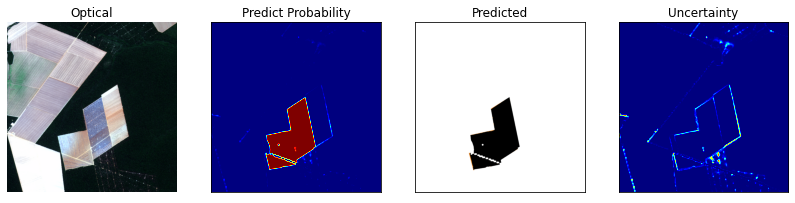

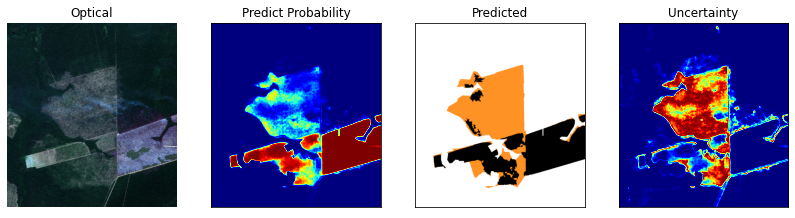

In [126]:


plotCropSampleFlag = True
if plotCropSampleFlag == True:
        importlib.reload(_metrics)
        # import matplotlib
        # customCmap = matplotlib.colors.ListedColormap(['black', 'red'])
        ic(dataset.previewLims1, dataset.previewLims2)
        lims = dataset.previewLims1
        ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]))
        lims = dataset.previewLims2
        ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True))

        _plt.plotCropSample4(image_stack[...,dataset.previewBands], mean_prob, 
                error_mask_to_show_rgb[...,::-1], pred_entropy_to_show, 
                lims = dataset.previewLims1, 
                titles = ['Optical', 'Predict Probability', 'Predicted', 'Uncertainty'],
                cmaps = [plt.cm.gray, 'jet', plt.cm.gray, 'jet'],
                maskBackground = [False, True, False, True],
                invertMask = [False, False, False, False])
        plt.savefig('figures/' + dataset.__class__.__name__ + 'PredictSampleUncertainty1.png', dpi=150, bbox_inches='tight')

        _plt.plotCropSample4(image_stack[...,dataset.previewBands], mean_prob, 
                error_mask_to_show_rgb[...,::-1], pred_entropy_to_show, 
                lims = dataset.previewLims2, 
                titles = ['Optical', 'Predict Probability', 'Predicted', 'Uncertainty'],
                cmaps = [plt.cm.gray, 'jet', plt.cm.gray, 'jet'],
                maskBackground = [False, True, False, True],
                invertMask = [False, False, False, False])
        plt.savefig('figures/' + dataset.__class__.__name__ + 'PredictSampleUncertainty2.png', dpi=150, bbox_inches='tight')

In [127]:
from enum import Enum
Predictor = Enum('Predictor', 'pred_var MI pred_entropy KL pred_entropy_single')
predictor = Predictor.pred_entropy
# predictor = Predictor.pred_var
# predictor = Predictor.MI
# predictor = Predictor.KL

# predictor = Predictor.pred_entropy_single

if predictor == Predictor.pred_var:
    uncertainty = pred_var_test
    uncertainty_val = pred_var_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Variance'
    best_threshold = 0.2
elif predictor == Predictor.MI:
    uncertainty = MI_test
    uncertainty_val = MI_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Mutual Information'
    best_threshold = 0.2
elif predictor == Predictor.pred_entropy:
    uncertainty = pred_entropy_test
    uncertainty_val = pred_entropy_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Entropy'
    best_threshold = 0.287
elif predictor == Predictor.KL:
    uncertainty = KL_test
    uncertainty_val = KL_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Entropy'
    best_threshold = 0.287

elif predictor == Predictor.pred_entropy_single:
    uncertainty = pred_entropy_single_test
    uncertainty_val = pred_entropy_single_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Entropy Single'
    best_threshold = 0.287


In [128]:
ic(np.min(uncertainty), np.mean(uncertainty), np.max(uncertainty))
ic(np.min(pred_entropy), np.mean(pred_entropy), np.max(pred_entropy))


ic| np.min(uncertainty): -1.4529397e-07
    np.mean(uncertainty): 0.0033543413
    np.max(uncertainty): 0.8973001
ic| np.min(pred_entropy): -0.0
    np.mean(pred_entropy): 0.0073958114
    np.max(pred_entropy): 0.36787948


(-0.0, 0.0073958114, 0.36787948)

In [129]:

y_test = error_mask_test
y_val = error_mask_val

ic(y_test.shape, uncertainty.shape)
pos_label = 1
ROCmode = 'val'
if ROCmode == 'test':
    fpr, tpr, thresholds = metrics.roc_curve(y_test, uncertainty, pos_label=pos_label)
elif ROCmode == 'val':
    fpr, tpr, thresholds = metrics.roc_curve(y_val, uncertainty_val, pos_label=pos_label)

roc_auc = metrics.auc(fpr, tpr)
ic(roc_auc)

ic| y_test.shape: (44616217,), uncertainty.shape: (44616217,)
ic| roc_auc: 0.9253552278366888


0.9253552278366888

Best Threshold=0.001731, G-Mean=0.905


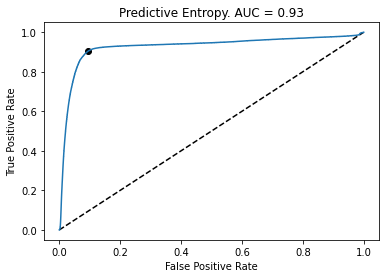

In [130]:
importlib.reload(_metrics)
plt.figure()
_metrics.plotAUC(fpr, tpr, roc_auc, modelId = title_name)
ix, best_threshold_uncertainty = _metrics.getBestThresholdGMean(fpr, tpr, thresholds)
# ix, best_threshold_uncertainty = _metrics.getBestThresholdJStatistic(fpr, tpr, thresholds)

_metrics.plotBestThreshold(fpr, tpr, ix)
plt.savefig(figures_path + title_name + ' roc_curve.png', dpi=200)

In [131]:
np.set_printoptions(suppress=False)
ic(best_threshold_uncertainty)
np.set_printoptions(suppress=True)


ic| best_threshold_uncertainty: 0.001730656


In [132]:
# best_threshold_uncertainty = 0.262948
# best_threshold_uncertainty = 0.08329400420188904

In [133]:
# threshold = 0.003254
y_pred_thresholded = np.zeros_like(uncertainty)
y_pred_thresholded[uncertainty >= best_threshold_uncertainty] = 1


In [134]:
metrics_error_detection = False
if metrics_error_detection == True:
    f1 = round(f1_score(error_mask_test, y_pred_thresholded)*100, 2)
    precision = round(metrics.precision_score(error_mask_test, y_pred_thresholded)*100, 2)
    recall = round(metrics.recall_score(error_mask_test, y_pred_thresholded)*100, 2)
    ic(f1, precision, recall)

    cm = metrics.confusion_matrix(error_mask_test, y_pred_thresholded)
    print(cm)

In [135]:
if metrics_error_detection == True:

    ic(best_threshold_uncertainty)

In [136]:
if metrics_error_detection == True:

    predicted_error_mask = np.zeros(pred_entropy.shape, dtype = np.uint8)
    predicted_error_mask[pred_entropy>=best_threshold_uncertainty] = 1
    predicted_error_mask = utils_v1.unpadIm(predicted_error_mask, npad)

    predicted_error_mask[label_mask == 2] = 0

In [137]:
if metrics_error_detection == True:

    # ic(np.unique(predicted_error_mask, return_counts=True))
    # ic(np.unique(error_mask, return_counts=True))
    predicted_error_mask_to_show = predicted_error_mask.copy()
    predicted_error_mask_to_show = np.abs(1 - predicted_error_mask_to_show)
    predicted_error_mask_to_show = predicted_error_mask_to_show.astype(np.uint8)*255
    predicted_error_mask_to_show = np.repeat(
        np.expand_dims(predicted_error_mask_to_show, axis=-1),
        3, axis = -1)
    fig, ax = plt.subplots(figsize=(15,15))
    ax.set_xticks([])
    ax.set_yticks([])

    ax.imshow(predicted_error_mask_to_show)


    title_name = 'ResUnet'
    fig.savefig('figures/Para' + title_name + 'predicted error mask.png', dpi=300, bbox_inches='tight')


In [138]:
if metrics_error_detection == True:

    predicted_error_mask_forest = predicted_error_mask.copy()
    predicted_error_mask_forest[predicted_unpad == 1] = 0
    ic(np.unique(predicted_unpad, return_counts=True))
    ic(np.unique(predicted_error_mask_forest, return_counts=True))

    plt.figure(figsize=(10,10))
    plt.imshow(predicted_error_mask, cmap=plt.cm.gray)
    title_name = 'ResUnet'
    plt.axis('off')
    plt.savefig('figures/Para' + title_name + 'predicted error mask forest.png', dpi=150, bbox_inches='tight')


In [139]:
if metrics_error_detection == True:

        importlib.reload(_metrics)
        _metrics.plotConfusionMatrix(cm)
        plt.savefig(figures_path + title_name + ' confusion matrix ROC threshold.png', 
                dpi=200, bbox_inches='tight')

In [140]:
label_mask_current_deforestation_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                label_mask_current_deforestation, mask_amazon_ts),
        label_mask_test)

predicted_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                predicted_unpad, mask_amazon_ts),
        label_mask_test)
        


Get precision-recall threshold

In [141]:
precision, recall, thresholds = metrics.precision_recall_curve(
            y_val, uncertainty_val, pos_label=pos_label)



In [142]:
ic(thresholds)

ic| thresholds: array([-0.00000011, -0.00000011, -0.00000011, ...,  0.9471891 ,
                        0.95507425,  0.9880866 ], dtype=float32)


array([-0.00000011, -0.00000011, -0.00000011, ...,  0.9471891 ,
        0.95507425,  0.9880866 ], dtype=float32)

In [143]:
fscore = (2 * precision * recall) / (precision + recall)
ix = np.nanargmax(fscore)
best_threshold_uncertainty = thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

C:\Users\jchamorro\AppData\Local\Temp\ipykernel_14804\3129774117.py:1: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


Best Threshold=0.032322, F-Score=0.104


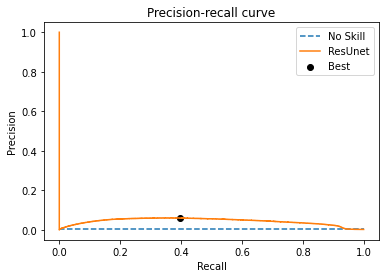

In [144]:
importlib.reload(_metrics)
_metrics.plotPrecisionRecall(y_val, precision, recall, ix)
plt.savefig('figures/' + 'Para' + 'prediction_recall_curve.png', dpi=150, bbox_inches='tight')

In [145]:
'''
# Metrics for th=0.5    
ProbList_05 = [0.5]

metrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)
print('Metrics th = 0.5: ', metrics_05*100)
'''


"\n# Metrics for th=0.5    \nProbList_05 = [0.5]\n\nmetrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)\nprint('Metrics th = 0.5: ', metrics_05*100)\n"

In [146]:
ic(np.min(uncertainty), np.average(uncertainty), np.max(uncertainty))

ic| np.min(uncertainty): -1.4529397e-07
    np.average(uncertainty): 0.0033543413
    np.max(uncertainty): 0.8973001


(-1.4529397e-07, 0.0033543413, 0.8973001)

In [147]:
# plt.hist(uncertainty)

In [148]:
ic(uncertainty.dtype, label_mask_current_deforestation_test.dtype, predicted_test.dtype)

ic| uncertainty.dtype: dtype('float32')
    label_mask_current_deforestation_test.dtype: dtype('uint8')
    predicted_test.dtype: dtype('float32')


(dtype('float32'), dtype('uint8'), dtype('float32'))

In [149]:
ic(uncertainty.shape, label_mask_current_deforestation_test.shape)
ic(np.unique(label_mask_current_deforestation_test))

ic| uncertainty.shape: (44616217,)
    label_mask_current_deforestation_test.shape: (44616217,)
ic| np.unique(label_mask_current_deforestation_test): array([0, 1], dtype=uint8)


array([0, 1], dtype=uint8)

In [150]:
ic(np.min(uncertainty), np.mean(uncertainty), np.max(uncertainty))

ic| np.min(uncertainty): -1.4529397e-07
    np.mean(uncertainty): 0.0033543413
    np.max(uncertainty): 0.8973001


(-1.4529397e-07, 0.0033543413, 0.8973001)

In [151]:
importlib.reload(_metrics)

threshold_uncertainty = 0.15

predicted_thresholded = np.zeros_like(uncertainty).astype(np.int8)
predicted_thresholded[uncertainty >= threshold_uncertainty] = 1
predicted_thresholded = predicted_thresholded.astype(np.uint8)
ic(predicted_thresholded.shape)


ic| predicted_thresholded.shape: (44616217,)


(44616217,)

In [152]:
ic(np.unique(predicted_thresholded, return_counts=True),
    np.unique(label_mask, return_counts=True),
    np.unique(mask_amazon_ts, return_counts=True))



ic| np.unique(predicted_thresholded, return_counts=True): (array([0, 1], dtype=uint8), array([44535112,    81105], dtype=int64))
    np.unique(label_mask, return_counts=True): (array([0, 1, 2], dtype=uint8),
                                                array([109933163,   2229121,  62841616], dtype=int64))
    np.unique(mask_amazon_ts, return_counts=True): (array([0, 1], dtype=uint8), array([105002340,  70001560], dtype=int64))


((array([0, 1], dtype=uint8), array([44535112,    81105], dtype=int64)),
 (array([0, 1, 2], dtype=uint8),
  array([109933163,   2229121,  62841616], dtype=int64)),
 (array([0, 1], dtype=uint8), array([105002340,  70001560], dtype=int64)))

In [153]:
def getUncertaintyPercentageFromTest(uncertainty_mask, 
        label_mask, mask_test):
    total_test_area = mask_test.copy()
    total_test_area[label_mask == 2] = 0

    percentage = np.count_nonzero(uncertainty_mask.flatten()) / np.count_nonzero(total_test_area.flatten())
    return total_test_area, percentage

total_test_area, percentage = getUncertaintyPercentageFromTest(predicted_thresholded, 
        label_mask, mask_amazon_ts)

ic(percentage)

ic| percentage: 0.0018178367744625234


0.0018178367744625234

In [154]:
AA = np.count_nonzero(predicted_thresholded.flatten()) / len(label_mask_current_deforestation_test)
ic(AA)

# metrics_values = _metrics.getAA_Recall(uncertainty, 
#                 label_mask_current_deforestation_test, 
#                 predicted_test, [threshold_uncertainty])


ic| AA: 0.0018178367744625234


0.0018178367744625234

In [155]:
predictor

<Predictor.KL: 4>

In [156]:

importlib.reload(_metrics)

# threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]

# threshold_list = [0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003]
if predictor == Predictor.pred_entropy:
        threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003, np.max(uncertainty)-0.0015]
elif predictor == Predictor.pred_var:
        threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                0.25, 0.27, 0.3, 0.34, 0.36]
        threshold_list = [x*0.13/0.36 for x in threshold_list] + [np.max(uncertainty)-0.0015, np.max(uncertainty)-0.0008]
elif predictor == Predictor.MI:
        threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                0.25, 0.27, 0.3, 0.34, 0.36]
        threshold_list = [x*0.235/0.36 for x in threshold_list] + [np.max(uncertainty)-0.003, np.max(uncertainty)-0.0015]
elif predictor == Predictor.KL:
        threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                0.25, 0.27, 0.3, 0.34, 0.36]
        threshold_list = [x*1.0/0.36 for x in threshold_list] + [np.max(uncertainty)-0.006, np.max(uncertainty)-0.003]
                
        # threshold_list = np.linspace(np.min(uncertainty) + 0.0015, np.max(uncertainty) - 0.0015, 19)
print(threshold_list)
loadThresholdMetrics = False
if loadThresholdMetrics == False:
        # threshold_list = [0.1]
        # y_test
        ic(uncertainty.shape, label_mask_current_deforestation_test.shape)
        importlib.reload(_metrics)

        metrics_values = _metrics.getAA_Recall(uncertainty, 
                label_mask_current_deforestation_test, 
                predicted_test, threshold_list)

        # ic(metrics_values)


ic| uncertainty.shape: (44616217,)
    label_mask_current_deforestation_test.shape: (44616217,)


[0.006944444444444445, 0.01388888888888889, 0.020833333333333332, 0.02777777777777778, 0.041666666666666664, 0.06944444444444445, 0.1388888888888889, 0.22222222222222224, 0.2777777777777778, 0.4166666666666667, 0.5555555555555556, 0.625, 0.6944444444444444, 0.7500000000000001, 0.8333333333333334, 0.9444444444444445, 1.0, 0.891300124168396, 0.894300124168396]
threshold 0.006944444444444445
(38396335,) (38396335,)


ic| label_current_deforestation_test_classified_incorrect.shape: (6219882,)
    predicted_test_classified_incorrect.shape: (6219882,)


cm_correct [[37856688    77671]
 [   21967   440009]]


ic| TP_H + FN_H + FP_H + TN_H: 6219882
    len(label_mask_current_deforestation_test): 44616217
ic| TP_H + FN_H + FP_H + TN_H: 6219882
    len(label_mask_current_deforestation_test): 44616217


cm_incorrect [[5762668   64395]
 [ 255253  137566]]
[0.8499633  0.95244991 0.51475383 0.13940855 0.68115131 0.350202  ]
threshold 0.01388888888888889
(41968922,) (41968922,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2647295,)
    predicted_test_classified_incorrect.shape: (2647295,)


cm_correct [[41338613    98534]
 [   50605   481170]]


ic| TP_H + FN_H + FP_H + TN_H: 2647295
    len(label_mask_current_deforestation_test): 44616217
ic| TP_H + FN_H + FP_H + TN_H: 2647295
    len(label_mask_current_deforestation_test): 44616217


cm_incorrect [[2280743   43532]
 [ 226615   96405]]
[0.83002705 0.90483757 0.5629069  0.05933482 0.68891716 0.29844901]
threshold 0.020833333333333332
(43258940,) (43258940,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1357277,)
    predicted_test_classified_incorrect.shape: (1357277,)
ic| TP_H + FN_H + FP_H + TN_H: 1357277
    len(label_mask_current_deforestation_test):

cm_correct [[42563344   109601]
 [   80321   505674]]
cm_incorrect [[1056012   32465]
 [ 196899   71901]]


 44616217
ic| TP_H + FN_H + FP_H + TN_H: 1357277
    len(label_mask_current_deforestation_test): 44616217


[0.82186664 0.86293228 0.59157342 0.03042116 0.68893126 0.26748884]
threshold 0.02777777777777778
(43719328,) (43719328,)


ic| label_current_deforestation_test_classified_incorrect.shape: (896889,)
    predicted_test_classified_incorrect.shape: (896889,)
ic| TP_H + FN_H + FP_H + TN_H: 896889
    len(label_mask_current_deforestation_test): 44616217
ic| TP_H + FN_H + FP_H + TN_H: 896889
    len(label_mask_current_deforestation_test): 44616217


cm_correct [[42979012   116462]
 [  104814   519040]]
cm_incorrect [[640344  25604]
 [172406  58535]]
[0.81674015 0.83198954 0.60720992 0.02010231 0.69569403 0.25346301]
threshold 0.041666666666666664
(44116324,) (44116324,)


ic| label_current_deforestation_test_classified_incorrect.shape: (499893,)
    predicted_test_classified_incorrect.shape: (499893,)
ic| TP_H + FN_H + FP_H + TN_H: 499893
    len(label_mask_current_deforestation_test): 44616217
ic| TP_H + FN_H + FP_H + TN_H: 499893
    len(label_mask_current_deforestation_test): 44616217


cm_correct [[43313704   125111]
 [  140844   536665]]
cm_incorrect [[305652  16955]
 [136376  40910]]
[0.8109466  0.79211494 0.62782889 0.01120429 0.70699041 0.23075708]
threshold 0.06944444444444445
(44365554,) (44365554,)


ic| label_current_deforestation_test_classified_incorrect.shape: (250663,)
    predicted_test_classified_incorrect.shape: (250663,)
ic| TP_H + FN_H + FP_H + TN_H: 250663
    len(label_mask_current_deforestation_test): 44616217
ic| TP_H + FN_H + FP_H + TN_H: 250663
    len(label_mask_current_deforestation_test): 44616217


cm_correct [[43496646   133361]
 [  183529   552018]]
cm_incorrect [[122710   8705]
 [ 93691  25557]]
[0.80542007 0.75048637 0.64578993 0.0056182  0.74592843 0.21431806]
threshold 0.1388888888888889
(44523343,) (44523343,)


ic| label_current_deforestation_test_classified_incorrect.shape: (92874,)
    predicted_test_classified_incorrect.shape: (92874,)
ic| TP_H + FN_H + FP_H + TN_H: 92874
    len(label_mask_current_deforestation_test): 44616217
ic| TP_H + FN_H + FP_H + TN_H: 92874
    len(label_mask_current_deforestation_test): 44616217


cm_correct [[43585236   139342]
 [  234291   564474]]
cm_incorrect [[34120  2724]
 [42929 13101]]
[0.80201928 0.70668344 0.66036184 0.00208162 0.8278673  0.23382117]
threshold 0.22222222222222224
(44576043,) (44576043,)


ic| label_current_deforestation_test_classified_incorrect.shape: (40174,)
    predicted_test_classified_incorrect.shape: (40174,)
ic| TP_H + FN_H + FP_H + TN_H: 40174
    len(label_mask_current_deforestation_test): 44616217
ic| TP_H + FN_H + FP_H + TN_H: 40174
    len(label_mask_current_deforestation_test): 44616217


cm_correct [[43606771   141087]
 [  257766   570419]]
cm_incorrect [[12585   979]
 [19454  7156]]
[0.80170652 0.68875795 0.66731673 0.00090043 0.87965581 0.26892146]
threshold 0.2777777777777778
(44591831,) (44591831,)


ic| label_current_deforestation_test_classified_incorrect.shape: (24386,)
    predicted_test_classified_incorrect.shape: (24386,)
ic| TP_H + FN_H + FP_H + TN_H: 24386
    len(label_mask_current_deforestation_test): 44616217
ic| TP_H + FN_H + FP_H + TN_H: 24386
    len(label_mask_current_deforestation_test): 44616217


cm_correct [[43611921   141461]
 [  265290   573159]]
cm_incorrect [[ 7435   605]
 [11930  4416]]
[0.80204724 0.68359435 0.67052217 0.00054657 0.87950607 0.27015784]
threshold 0.4166666666666667
(44610078,) (44610078,)


ic| label_current_deforestation_test_classified_incorrect.shape: (6139,)
    predicted_test_classified_incorrect.shape: (6139,)
ic| TP_H + FN_H + FP_H + TN_H: 6139
    len(label_mask_current_deforestation_test): 44616217
ic| TP_H + FN_H + FP_H + TN_H: 6139
    len(label_mask_current_deforestation_test): 44616217


cm_correct [[43617776   141935]
 [  273452   576915]]
cm_incorrect [[1580  131]
 [3768  660]]
[0.80255269 0.67843061 0.67491621 0.0001376  0.83438685 0.14905149]
threshold 0.5555555555555556
(44614873,) (44614873,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1344,)
    predicted_test_classified_incorrect.shape: (1344,)
ic| TP_H + FN_H + FP_H + TN_H: 1344
    len(label_mask_current_deforestation_test): 44616217
ic| TP_H + FN_H + FP_H + TN_H: 1344
    len(label_mask_current_deforestation_test): 44616217


cm_correct [[43619252   142037]
 [  276050   577534]]
cm_incorrect [[ 104   29]
 [1170   41]]
[0.80260878 0.67659891 0.67564036 0.00003012 0.58571429 0.03385632]
threshold 0.625
(44615665,) (44615665,)


ic| label_current_deforestation_test_classified_incorrect.shape: (552,)
    predicted_test_classified_incorrect.shape: (552,)
ic| TP_H + FN_H + FP_H + TN_H: 552
    len(label_mask_current_deforestation_test): 44616217
ic| TP_H + FN_H + FP_H + TN_H: 552
    len(label_mask_current_deforestation_test): 44616217


cm_correct [[43619312   142065]
 [  276715   577573]]
cm_incorrect [[ 44   1]
 [505   2]]
[0.80258825 0.67608699 0.67568598 0.00001237 0.66666667 0.00394477]
threshold 0.6944444444444444
(44616040,) (44616040,)


ic| label_current_deforestation_test_classified_incorrect.shape: (177,)
    predicted_test_classified_incorrect.shape: (177,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:299: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 177
    len(label_mask_current_deforestation_test): 44616217
ic| TP_H + FN_H + FP_H + TN_H: 177
    len(label_mask_current_deforestation_test): 44616217


cm_correct [[43619352   142066]
 [  277047   577575]]
cm_incorrect [[  4   0]
 [173   0]]
[0.80258768 0.6758251  0.67568832 0.00000397        nan 0.        ]
threshold 0.7500000000000001
(44616134,) (44616134,)


ic| label_current_deforestation_test_classified_incorrect.shape: (83,)
    predicted_test_classified_incorrect.shape: (83,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:299: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 83
    len(label_mask_current_deforestation_test): 44616217
ic| TP_H + FN_H + FP_H + TN_H: 83
    len(label_mask_current_deforestation_test): 44616217


cm_correct [[43619356   142066]
 [  277137   577575]]
cm_incorrect [[ 0  0]
 [83  0]]
[0.80258768 0.67575394 0.67568832 0.00000186        nan 0.        ]
threshold 0.8333333333333334
(44616189,) (44616189,)


ic| label_current_deforestation_test_classified_incorrect.shape: (28,)
    predicted_test_classified_incorrect.shape: (28,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:299: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 28
    len(label_mask_current_deforestation_test): 44616217
ic| TP_H + FN_H + FP_H + TN_H: 28
    len(label_mask_current_deforestation_test): 44616217


cm_correct [[43619356   142066]
 [  277192   577575]]
cm_incorrect [[ 0  0]
 [28  0]]
[0.80258768 0.67571046 0.67568832 0.00000063        nan 0.        ]
threshold 0.9444444444444445
(44616217,) (44616217,)


ic| label_current_deforestation_test_classified_incorrect.shape: (0,)
    predicted_test_classified_incorrect.shape: (0,)
ic| np.all(label_current_deforestation_test_classified_incorrect) == 0: False
ic| np.all(predicted_test_classified_incorrect) == 0: False


cm_correct [[43619356   142066]
 [  277220   577575]]
cm_incorrect []
[nan nan nan  0. nan nan]
threshold 1.0
(44616217,) (44616217,)


ic| label_current_deforestation_test_classified_incorrect.shape: (0,)
    predicted_test_classified_incorrect.shape: (0,)
ic| np.all(label_current_deforestation_test_classified_incorrect) == 0: False
ic| np.all(predicted_test_classified_incorrect) == 0: False


cm_correct [[43619356   142066]
 [  277220   577575]]
cm_incorrect []
[nan nan nan  0. nan nan]
threshold 0.891300124168396
(44616216,) (44616216,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1,)
    predicted_test_classified_incorrect.shape: (1,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:299: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 1
    len(label_mask_current_deforestation_test): 44616217
ic| TP_H + FN_H + FP_H + TN_H: 1
    len(label_mask_current_deforestation_test): 44616217


cm_correct [[43619356   142066]
 [  277219   577575]]
cm_incorrect [[0 0]
 [1 0]]
[0.80258768 0.67568911 0.67568832 0.00000002        nan 0.        ]
threshold 0.894300124168396
(44616216,) (44616216,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1,)
    predicted_test_classified_incorrect.shape: (1,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:299: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 1
    len(label_mask_current_deforestation_test): 44616217
ic| TP_H + FN_H + FP_H + TN_H: 1
    len(label_mask_current_deforestation_test): 44616217


cm_correct [[43619356   142066]
 [  277219   577575]]
cm_incorrect [[0 0]
 [1 0]]
[0.80258768 0.67568911 0.67568832 0.00000002        nan 0.        ]


In [157]:

if loadThresholdMetrics == False:
        # threshold_list = [0.1]
        # y_test
        ic(uncertainty.shape, label_mask_current_deforestation_test.shape)
        importlib.reload(_metrics)

        metric_values_audited = _metrics.getUncertaintyMetricsAudited(uncertainty, 
                label_mask_current_deforestation_test, 
                predicted_test, threshold_list)

        ic(metric_values_audited)



ic| uncertainty.shape: (44616217,)
    label_mask_current_deforestation_test.shape: (44616217,)


threshold 0.006944444444444445
(44616217,) (44616217,)
cm_audited [[43683751    77671]
 [   21967   832828]]
[0.91469403 0.97430144]
threshold 0.01388888888888889
(44616217,) (44616217,)
cm_audited [[43662888    98534]
 [   50605   804190]]
[0.89084814 0.94079867]
threshold 0.020833333333333332
(44616217,) (44616217,)


In [ ]:
m_audited = {'precision': metric_values_audited[:,0],
        'recall': metric_values_audited[:,1]}



In [ ]:
'''
threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34]
importlib.reload(_metrics)

metrics = _metrics.getF1byThreshold(uncertainty,
    error_mask, threshold_list)

ic(metrics)
'''

'\nthreshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34]\nimportlib.reload(_metrics)\n\nmetrics = _metrics.getF1byThreshold(uncertainty,\n    error_mask, threshold_list)\n\nic(metrics)\n'

In [ ]:
if loadThresholdMetrics == False:

    np.save('metrics.npy', metrics_values)
if loadThresholdMetrics == True:
    metrics_values = np.load('metrics.npy')


In [ ]:
save_figures = True

In [ ]:
m = {'precision_L': metrics_values[:,0],
        'recall_L': metrics_values[:,1],
        'recall_Ltotal': metrics_values[:,2],
        'AA': metrics_values[:,3],
        'precision_H': metrics_values[:,4],
        'recall_H': metrics_values[:,5]}

m['f1_L'] = 2*m['precision_L']*m['recall_L']/(m['precision_L']+m['recall_L'])
m['f1_H'] = 2*m['precision_H']*m['recall_H']/(m['precision_H']+m['recall_H'])

m_audited['f1'] = 2*m_audited['precision']*m_audited['recall']/(m_audited['precision']+m_audited['recall'])

C:\Users\jchamorro\AppData\Local\Temp\ipykernel_9916\1528772010.py:9: RuntimeWarning: invalid value encountered in true_divide
  m['f1_H'] = 2*m['precision_H']*m['recall_H']/(m['precision_H']+m['recall_H'])


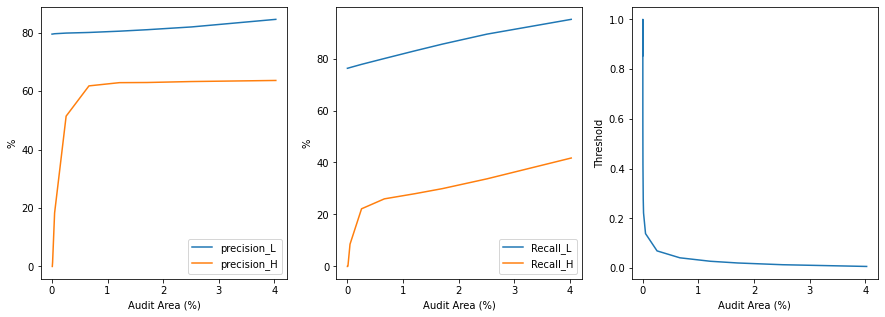

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m['AA']*100, m['precision_L']*100, label="precision_L")
ax1.plot(m['AA']*100, m['precision_H']*100, label="precision_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(m['AA']*100, m['recall_L']*100, label="Recall_L")
ax2.plot(m['AA']*100, m['recall_H']*100, label="Recall_H")
ax2.legend(loc="lower right")
ax2.set_ylabel('%')
ax2.set_xlabel('Audit Area (%)')

ax3.plot(m['AA']*100, np.asarray(threshold_list), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_AA.png', dpi=150, bbox_inches='tight')

In [ ]:
xlim = [-0.3, 12.7]
xlim = [-0.1, 10.4]

ylim = [0, 105]


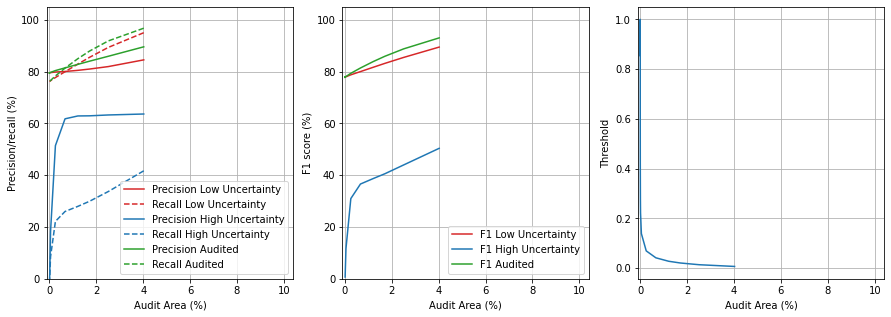

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m['AA']*100, m['precision_L']*100, 'C3-', label="Precision Low Uncertainty")
ax1.plot(m['AA']*100, m['recall_L']*100, 'C3--', label="Recall Low Uncertainty")
ax1.plot(m['AA']*100, m['precision_H']*100, 'C0-', label="Precision High Uncertainty")
ax1.plot(m['AA']*100, m['recall_H']*100, 'C0--', label="Recall High Uncertainty")
ax1.plot(m['AA']*100, m_audited['precision']*100, 'C2-', label="Precision Audited")
ax1.plot(m['AA']*100, m_audited['recall']*100, 'C2--', label="Recall Audited")

ax1.legend(loc="lower right")
ax1.set_ylabel('Precision/recall (%)')
ax1.set_xlabel('Audit Area (%)')
ax1.set_ylim(ylim)
ax1.set_xlim(xlim)
ax1.grid()
ax2.plot(m['AA']*100, m['f1_L']*100, 'C3-', label="F1 Low Uncertainty")
ax2.plot(m['AA']*100, m['f1_H']*100, 'C0-', label="F1 High Uncertainty")
ax2.plot(m['AA']*100, m_audited['f1']*100, 'C2-', label="F1 Audited")

ax2.legend(loc="lower right")
ax2.set_ylabel('F1 score (%)')
ax2.set_xlabel('Audit Area (%)')
ax2.set_ylim(ylim)
ax2.set_xlim(xlim)

ax2.grid()
ax3.plot(m['AA']*100, np.asarray(threshold_list), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')
ax3.grid()
ax3.set_xlim(xlim)

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_f1_AA.png', dpi=150, bbox_inches='tight')

In [ ]:


m

{'precision_L': array([0.84576129, 0.81981207, 0.81030101, 0.80527518, 0.8008829 ,
        0.79877276, 0.79653321, 0.79548049, 0.79530883, 0.79528546,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan]),
 'recall_L': array([0.95069319, 0.89386482, 0.85549069, 0.82953454, 0.80002498,
        0.77752291, 0.7652003 , 0.76296067, 0.76257991, 0.76239462,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan]),
 'recall_Ltotal': array([0.61509271, 0.68275206, 0.7122107 , 0.72817246, 0.74422811,
        0.75631651, 0.76200917, 0.76236247, 0.76236599, 0.76236599,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan]),
 'AA': array([0.0402391 , 0.02510234, 0.01709807, 0.01213145, 0.00665971,
        0.00255645, 0.00048433, 0.00012609, 0.00007199, 0.00001986,
        0.00000439, 0.000001

In [ ]:
m_audited

{'precision': array([0.89616271, 0.85962212, 0.84066268, 0.8284559 , 0.81478396,
        0.80440689, 0.79741632, 0.79564767, 0.79536872, 0.79529348,
        0.79528546, 0.79528546, 0.79528546, 0.79528546, 0.79528546,
        0.79528546, 0.79528546, 0.79528546, 0.79528546]),
 'recall': array([0.96809879, 0.9189318 , 0.87969351, 0.85036398, 0.81397202,
        0.78359081, 0.76617948, 0.76314653, 0.76264651, 0.76240355,
        0.76236599, 0.76236599, 0.76236599, 0.76236599, 0.76236599,
        0.76236599, 0.76236599, 0.76236599, 0.76236599]),
 'f1': array([0.93074286, 0.88828805, 0.85973534, 0.83926699, 0.81437779,
        0.79386242, 0.78148588, 0.77905827, 0.77866399, 0.77850129,
        0.77847786, 0.77847786, 0.77847786, 0.77847786, 0.77847786,
        0.77847786, 0.77847786, 0.77847786, 0.77847786])}

In [ ]:
exp

111

In [ ]:
threshold_list

[0.006944444444444445,
 0.01388888888888889,
 0.020833333333333332,
 0.02777777777777778,
 0.041666666666666664,
 0.06944444444444445,
 0.1388888888888889,
 0.22222222222222224,
 0.2777777777777778,
 0.4166666666666667,
 0.5555555555555556,
 0.625,
 0.6944444444444444,
 0.7500000000000001,
 0.8333333333333334,
 0.9444444444444445,
 1.0,
 0.8528447570800781,
 0.8558447570800781]

In [ ]:
# threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
#         0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003, np.max(uncertainty)-0.0015]


In [ ]:
predictor

<Predictor.KL: 4>

In [ ]:

importlib.reload(_metrics)


# threshold_list = [0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
#         0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003, np.max(uncertainty)-0.0015]
#threshold_list2 = [0.09] # exp 77 PA 50 runs
# threshold_list2 = [0.085] # exp 77 PA 30 runs
# threshold_list2 = [0.085] # exp 77 PA 10 runs
# threshold_list2 = [0.083] # exp 77 PA 5 runs
threshold_list2 = [0.065] # exp 77 PA 5 runs
threshold_list2 = [0.06] # exp 77 PA 5 runs
threshold_list2 = [0.0825] # exp 77 PA 3 runs
if predictor == Predictor.pred_entropy:
        if exp == 90:
                threshold_list2 = [0.14]
        elif exp == 91:
                threshold_list2 = [0.16]
        elif exp == 92:
                threshold_list2 = [0.125]
        elif exp == 93:
                threshold_list2 = [0.13]
        elif exp == 94:
                threshold_list2 = [0.217]
        elif exp == 95:
                threshold_list2 = [0.217]
        elif exp == 96:
                threshold_list2 = [0.115]
        elif exp == 97:
                threshold_list2 = [0.127]
        elif exp == 98:
                threshold_list2 = [0.133]
        elif exp == 99:
                threshold_list2 = [0.197]
        elif exp == 100:
                threshold_list2 = [0.112]
        elif exp == 101:
                threshold_list2 = [0.101]
        elif exp == 102:
                threshold_list2 = [0.05]

        elif exp == 103:
                threshold_list2 = [0.13]
        elif exp == 104:
                threshold_list2 = [0.173]
        elif exp == 105:
                threshold_list2 = [0.11]
        elif exp == 106:
                threshold_list2 = [0.159]
        elif exp == 107:
                threshold_list2 = [0.238]


        # MT
        elif exp == 108:
                threshold_list2 = [0.112] # 0.1, 0.15
        elif exp == 109:
                threshold_list2 = [0.1113] # 0.1, 0.15
        elif exp == 110:
                threshold_list2 = [0.128] # 0.1, 0.15
        elif exp == 111:
                threshold_list2 = [0.077] # 0.05, 0.08

        # repeating experiments. Para 2018-2019
        # threshold_list2 = [0.262]
        # threshold_list2 = [0.151]
        # threshold_list2 = [0.215]
        # threshold_list2 = [0.144]


elif  predictor == Predictor.pred_var:
        threshold_list2 = [0.00325] # 0.0027083333333333334, 0.003611111111111112
        threshold_list2 = [0.00227] # 0.001805555555555556, 0.0027083333333333334
        if exp == 103:
                threshold_list2 = [0.0024] # 0.001805555555555556, 0.0027083333333333334
        elif exp == 104:
                threshold_list2 = [0.00288] # 0.0027, 0.0036
        elif exp == 105:
                threshold_list2 = [0.00155] # 0.0009, 0.0018
        elif exp == 106:
                threshold_list2 = [0.00225] # 0.0018, 0.0027
        elif exp == 107:
                threshold_list2 = [0.005] # 0.0036, 0.0054

        # MT
        elif exp == 108:
                threshold_list2 = [0.00204] # 0.001805, 0.002708
        elif exp == 109:
                threshold_list2 = [0.00218] # 0.001805, 0.002708
        elif exp == 110:
                threshold_list2 = [0.00218] # 0.001805, 0.002708
        elif exp == 111:
                threshold_list2 = [0.00077] # <0.0009

elif  predictor == Predictor.MI:
        threshold_list2 = [0.042] # 0.032, 0.052
        threshold_list2 = [0.013] # 0.0097, 0.016
        threshold_list2 = [0.015] # 0.0097, 0.016
        if exp == 103:
                threshold_list2 = [0.0136] # 0.0097, 0.016
        elif exp == 104:
                threshold_list2 = [0.0139] # 0.0097, 0.016
        elif exp == 105:
                threshold_list2 = [0.0129] # 0.0097, 0.016
        elif exp == 106:
                threshold_list2 = [0.0117] # 0.0163, 0.0326
        elif exp == 107:
                threshold_list2 = [0.0185] # 0.0163, 0.0326

        # MT
        elif exp == 108:
                threshold_list2 = [0.0145] # 0.00979, 0.01631
        elif exp == 109:
                threshold_list2 = [0.0173] # 0.016319, 0.032638
        elif exp == 110:
                threshold_list2 = [0.0145] # 0.016319, 0.01631
        elif exp == 111:
                threshold_list2 = [0.0077] # 0.006527, 0.009791



elif predictor == Predictor.KL:
        if exp == 103:
                threshold_list2 = [0.0188] # 0.014, 0.02
        elif exp == 104:
                threshold_list2 = [0.0205] # 0.014, 0.02088
        elif exp == 105:
                threshold_list2 = [0.0194] # 0.01388, 0.02083
        elif exp == 106:
                threshold_list2 = [0.0155] # 0.01388, 0.02083
        elif exp == 107:
                threshold_list2 = [0.0258] # 0.02083, 0.02777

        # MT
        elif exp == 108:
                threshold_list2 = [0.022] # 0.02083, 0.02777
        elif exp == 109:
                threshold_list2 = [0.0293] # 0.0277, 0.04166
        elif exp == 110:
                threshold_list2 = [0.0225] # 0.020833, 0.02777
        elif exp == 111:
                threshold_list2 = [0.011] # 0.00694, 0.01388


ic(uncertainty.shape, label_mask_current_deforestation_test.shape)

metrics_values2 = _metrics.getAA_Recall(uncertainty, 
        label_mask_current_deforestation_test, 
        predicted_test, threshold_list2)

metric_values_audited2 = _metrics.getUncertaintyMetricsAudited(uncertainty, 
        label_mask_current_deforestation_test, 
        predicted_test, threshold_list2)



ic| uncertainty.shape: (44601772,)
    label_mask_current_deforestation_test.shape: (44601772,)


threshold 0.011
(43260967,) (43260967,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1340805,)
    predicted_test_classified_incorrect.shape: (1340805,)
ic

cm_correct [[42527017   117854]
 [   51990   564106]]
cm_incorrect [[1055589   49338]
 [ 150468   85410]]


| TP_H + FN_H + FP_H + TN_H: 1340805
    len(label_mask_current_deforestation_test): 44601772
ic| TP_H + FN_H + FP_H + TN_H: 1340805
    len(label_mask_current_deforestation_test): 44601772


[0.82718341 0.9156138  0.66211645 0.0300617  0.63384985 0.36209396]
threshold 0.011
(44601772,) (44601772,)
cm_audited [[43631944   117854]
 [   51990   799984]]
[0.87159608 0.93897701]


In [ ]:
m2 = {'precision_L': metrics_values2[:,0],
        'recall_L': metrics_values2[:,1],
        'recall_Ltotal': metrics_values2[:,2],
        'AA': metrics_values2[:,3],
        'precision_H': metrics_values2[:,4],
        'recall_H': metrics_values2[:,5]}

m_audited2 = {'precision': metric_values_audited2[:,0],
        'recall': metric_values_audited2[:,1]}

m2['f1_L'] = 2*m2['precision_L']*m2['recall_L']/(m2['precision_L']+m2['recall_L'])
m2['f1_H'] = 2*m2['precision_H']*m2['recall_H']/(m2['precision_H']+m2['recall_H'])

m_audited2['f1'] = 2*m_audited2['precision']*m_audited2['recall']/(m_audited2['precision']+m_audited2['recall'])

ic(m2)
ic(m_audited2)


ic| m2: {'AA': array([0.0300617]),
         'f1_H': array([0.46089589]),
         'f1_L': array([0.86915511]),
         'precision_H': array([0.63384985]),
         'precision_L': array([0.82718341]),
         'recall_H': array([0.36209396]),
         'recall_L': array([0.9156138]),
         'recall_Ltotal': array([0.66211645])}
ic| m_audited2: {'f1': array([0.90403274]),
                 'precision': array([0.87159608]),
                 'recall': array([0.93897701])}


{'precision': array([0.87159608]),
 'recall': array([0.93897701]),
 'f1': array([0.90403274])}

In [ ]:
pred_entropy_unpad = utils_v1.unpadIm(pred_entropy, npad)
ic(pred_entropy_unpad.shape)

threshold_uncertainty = 0.1

uncertainty_mask = np.zeros_like(pred_entropy_unpad).astype(np.int8)
uncertainty_mask[pred_entropy_unpad >= threshold_uncertainty] = 1
ic(np.unique(uncertainty_mask, return_counts=True))


ic| pred_entropy_unpad.shape: (16795, 10420)
ic| np.unique(uncertainty_mask, return_counts=True): (array([0, 1], dtype=int8), array([171400669,   3603231], dtype=int64))


(array([0, 1], dtype=int8), array([171400669,   3603231], dtype=int64))

(-0.5, 10419.5, 16794.5, -0.5)

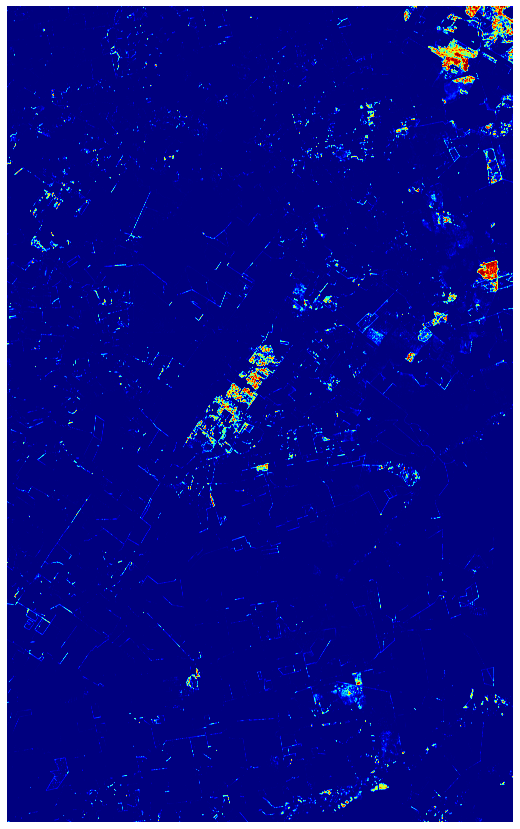

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(pred_entropy_to_show, cmap='jet')
plt.axis('off')


(-0.5, 10419.5, 16794.5, -0.5)

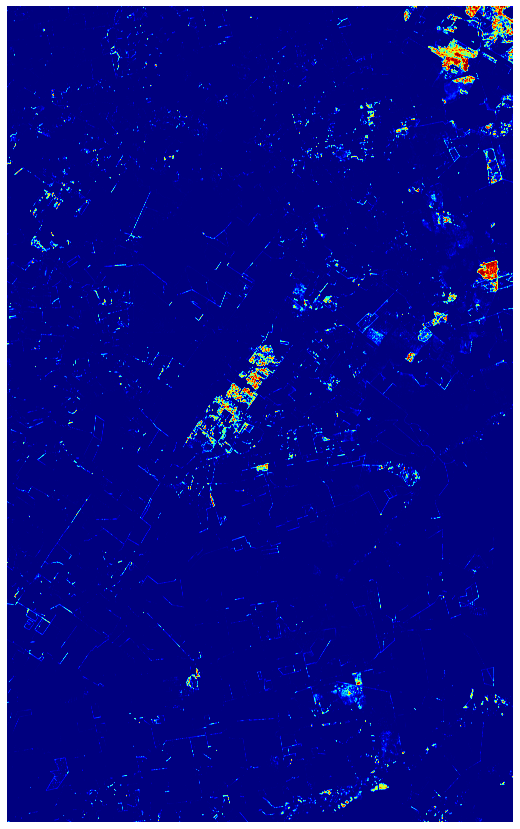

In [ ]:

fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(pred_entropy_to_show, cmap='jet')
plt.axis('off')


(-0.5, 10419.5, 16794.5, -0.5)

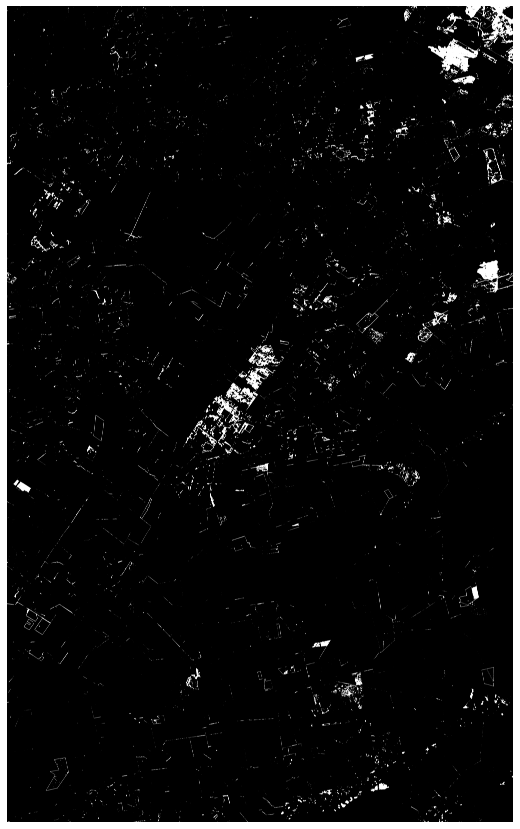

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(uncertainty_mask, cmap=plt.cm.gray)
plt.axis('off')


In [ ]:
# np.unique(label_mask_val_valid, return_counts=True)

In [ ]:
'''
importlib.reload(_metrics)

threshold_list_val = [0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]

loadThresholdMetrics = False
if loadThresholdMetrics == False:
        # threshold_list_val = [0.1]
        # y_test
        ic(uncertainty_val.shape, label_mask_val_valid.shape)
        importlib.reload(_metrics)

        metrics_values_val = _metrics.getAA_Recall(uncertainty_val, 
                label_mask_val_valid, 
                predicted_val, threshold_list_val)

        ic(metrics_values_val)
'''


'\nimportlib.reload(_metrics)\n\nthreshold_list_val = [0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]\n\nloadThresholdMetrics = False\nif loadThresholdMetrics == False:\n        # threshold_list_val = [0.1]\n        # y_test\n        ic(uncertainty_val.shape, label_mask_val_valid.shape)\n        importlib.reload(_metrics)\n\n        metrics_values_val = _metrics.getAA_Recall(uncertainty_val, \n                label_mask_val_valid, \n                predicted_val, threshold_list_val)\n\n        ic(metrics_values_val)\n'

In [ ]:
'''
m_val = {'precision_L': metrics_values_val[:,0],
        'recall_L': metrics_values_val[:,1],
        'recall_Ltotal': metrics_values_val[:,2],
        'AA': metrics_values_val[:,3],
        'precision_H': metrics_values_val[:,4],
        'recall_H': metrics_values_val[:,5]}


save_figures=False
'''

"\nm_val = {'precision_L': metrics_values_val[:,0],\n        'recall_L': metrics_values_val[:,1],\n        'recall_Ltotal': metrics_values_val[:,2],\n        'AA': metrics_values_val[:,3],\n        'precision_H': metrics_values_val[:,4],\n        'recall_H': metrics_values_val[:,5]}\n\n\nsave_figures=False\n"

In [ ]:
# threshold_list_val = [0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]


In [ ]:
'''
plt.plot(m_val['precision_L']*100, m_val['AA']*100)
plt.title('Precision vs. To-Audit Area')
plt.xlabel('Precision (%)')
plt.ylabel('Audit Area (%)')
if True:
    plt.savefig('figures/precision_AA_val.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m_val['precision_L']*100, m_val['AA']*100)\nplt.title('Precision vs. To-Audit Area')\nplt.xlabel('Precision (%)')\nplt.ylabel('Audit Area (%)')\nif True:\n    plt.savefig('figures/precision_AA_val.png', dpi=150, bbox_inches='tight')\n"

In [ ]:
'''
plt.plot(m_val['precision_L']*100, np.asarray(threshold_list_val))
plt.title('Precision vs. Threshold')
plt.xlabel('Precision (%)')
plt.ylabel('Threshold')
if True:
    plt.savefig('figures/precision_total_threshold_val.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m_val['precision_L']*100, np.asarray(threshold_list_val))\nplt.title('Precision vs. Threshold')\nplt.xlabel('Precision (%)')\nplt.ylabel('Threshold')\nif True:\n    plt.savefig('figures/precision_total_threshold_val.png', dpi=150, bbox_inches='tight')\n"

In [ ]:
'''
plt.plot(m_val['recall_Ltotal']*100, m_val['AA']*100)
plt.title('Recall total vs. To-Audit Area')
plt.xlabel('Recall (%)')
plt.ylabel('Audit Area (%)')
if True:
    plt.savefig('figures/recall_total_AA_val.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m_val['recall_Ltotal']*100, m_val['AA']*100)\nplt.title('Recall total vs. To-Audit Area')\nplt.xlabel('Recall (%)')\nplt.ylabel('Audit Area (%)')\nif True:\n    plt.savefig('figures/recall_total_AA_val.png', dpi=150, bbox_inches='tight')\n"

In [ ]:
'''
plt.plot(m_val['recall_Ltotal']*100, np.asarray(threshold_list_val))
plt.title('Recall total vs. Threshold')
plt.xlabel('Recall (%)')
plt.ylabel('Threshold')
if True:
    plt.savefig('figures/recall_total_threshold_val.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m_val['recall_Ltotal']*100, np.asarray(threshold_list_val))\nplt.title('Recall total vs. Threshold')\nplt.xlabel('Recall (%)')\nplt.ylabel('Threshold')\nif True:\n    plt.savefig('figures/recall_total_threshold_val.png', dpi=150, bbox_inches='tight')\n"

In [ ]:
'''
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m_val['AA']*100, m_val['precision_L']*100, label="precision_L")
ax1.plot(m_val['AA']*100, m_val['precision_H']*100, label="precision_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(m_val['AA']*100, m_val['recall_L']*100, label="Recall_L")
ax2.plot(m_val['AA']*100, m_val['recall_H']*100, label="Recall_H")
ax2.legend(loc="lower right")
ax2.set_ylabel('%')
ax2.set_xlabel('Audit Area (%)')

ax3.plot(m_val['AA']*100, np.asarray(threshold_list_val), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_AA_val.png', dpi=150, bbox_inches='tight')
'''

'\nfig, (ax1, ax2, ax3) = plt.subplots(1, 3)\nfig.set_figheight(5)\nfig.set_figwidth(15)\nax1.plot(m_val[\'AA\']*100, m_val[\'precision_L\']*100, label="precision_L")\nax1.plot(m_val[\'AA\']*100, m_val[\'precision_H\']*100, label="precision_H")\nax1.legend(loc="lower right")\nax1.set_ylabel(\'%\')\nax1.set_xlabel(\'Audit Area (%)\')\n\nax2.plot(m_val[\'AA\']*100, m_val[\'recall_L\']*100, label="Recall_L")\nax2.plot(m_val[\'AA\']*100, m_val[\'recall_H\']*100, label="Recall_H")\nax2.legend(loc="lower right")\nax2.set_ylabel(\'%\')\nax2.set_xlabel(\'Audit Area (%)\')\n\nax3.plot(m_val[\'AA\']*100, np.asarray(threshold_list_val), label="AA")\nax3.set_xlabel(\'Audit Area (%)\')\nax3.set_ylabel(\'Threshold\')\n\n# if save_figures == True:\nif True:\n    plt.savefig(\'figures/recall_precision_AA_val.png\', dpi=150, bbox_inches=\'tight\')\n'

In [ ]:
'''
m_val['f1_L'] = 2*m_val['precision_L']*m_val['recall_L']/(m_val['precision_L']+m_val['recall_L'])
m_val['f1_H'] = 2*m_val['precision_H']*m_val['recall_H']/(m_val['precision_H']+m_val['recall_H'])

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m_val['AA']*100, m_val['f1_L']*100, label="f1_L")
ax1.plot(m_val['AA']*100, m_val['f1_H']*100, label="f1_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(m_val['AA']*100, np.asarray(threshold_list_val), label="AA")
ax2.set_xlabel('Audit Area (%)')
ax2.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('figures/f1_AA_val.png', dpi=150, bbox_inches='tight')
'''

'\nm_val[\'f1_L\'] = 2*m_val[\'precision_L\']*m_val[\'recall_L\']/(m_val[\'precision_L\']+m_val[\'recall_L\'])\nm_val[\'f1_H\'] = 2*m_val[\'precision_H\']*m_val[\'recall_H\']/(m_val[\'precision_H\']+m_val[\'recall_H\'])\n\nfig, (ax1, ax2) = plt.subplots(1, 2)\nfig.set_figheight(5)\nfig.set_figwidth(15)\nax1.plot(m_val[\'AA\']*100, m_val[\'f1_L\']*100, label="f1_L")\nax1.plot(m_val[\'AA\']*100, m_val[\'f1_H\']*100, label="f1_H")\nax1.legend(loc="lower right")\nax1.set_ylabel(\'%\')\nax1.set_xlabel(\'Audit Area (%)\')\n\nax2.plot(m_val[\'AA\']*100, np.asarray(threshold_list_val), label="AA")\nax2.set_xlabel(\'Audit Area (%)\')\nax2.set_ylabel(\'Threshold\')\n\n# if save_figures == True:\nif True:\n    plt.savefig(\'figures/f1_AA_val.png\', dpi=150, bbox_inches=\'tight\')\n'

In [ ]:
'''
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m_val['AA']*100, m_val['precision_L']*100, 'C0-', label="Precision Low Uncertainty")
ax1.plot(m_val['AA']*100, m_val['recall_L']*100, 'C0--', label="Recall Low Uncertainty")
ax1.plot(m_val['AA']*100, m_val['precision_H']*100, 'C1-', label="Precision High Uncertainty")
ax1.plot(m_val['AA']*100, m_val['recall_H']*100, 'C1--', label="Recall High Uncertainty")
ax1.legend(loc="lower right")
ax1.set_ylabel('Precision/recall (%)')
ax1.set_xlabel('Audit Area (%)')
ax1.set_ylim(ylim)
ax1.set_xlim(xlim)

ax2.plot(m_val['AA']*100, m_val['f1_L']*100, label="F1 Low Uncertainty")
ax2.plot(m_val['AA']*100, m_val['f1_H']*100, label="F1 High Uncertainty")
ax2.legend(loc="lower right")
ax2.set_ylabel('F1 score (%)')
ax2.set_xlabel('Audit Area (%)')
ax2.set_ylim(ylim)
ax2.set_xlim(xlim)

ax3.plot(m_val['AA']*100, np.asarray(threshold_list_val), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')
ax3.set_xlim(xlim)

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_AA_val.png', dpi=150, bbox_inches='tight')
'''

'\nfig, (ax1, ax2, ax3) = plt.subplots(1, 3)\nfig.set_figheight(5)\nfig.set_figwidth(15)\nax1.plot(m_val[\'AA\']*100, m_val[\'precision_L\']*100, \'C0-\', label="Precision Low Uncertainty")\nax1.plot(m_val[\'AA\']*100, m_val[\'recall_L\']*100, \'C0--\', label="Recall Low Uncertainty")\nax1.plot(m_val[\'AA\']*100, m_val[\'precision_H\']*100, \'C1-\', label="Precision High Uncertainty")\nax1.plot(m_val[\'AA\']*100, m_val[\'recall_H\']*100, \'C1--\', label="Recall High Uncertainty")\nax1.legend(loc="lower right")\nax1.set_ylabel(\'Precision/recall (%)\')\nax1.set_xlabel(\'Audit Area (%)\')\nax1.set_ylim(ylim)\nax1.set_xlim(xlim)\n\nax2.plot(m_val[\'AA\']*100, m_val[\'f1_L\']*100, label="F1 Low Uncertainty")\nax2.plot(m_val[\'AA\']*100, m_val[\'f1_H\']*100, label="F1 High Uncertainty")\nax2.legend(loc="lower right")\nax2.set_ylabel(\'F1 score (%)\')\nax2.set_xlabel(\'Audit Area (%)\')\nax2.set_ylim(ylim)\nax2.set_xlim(xlim)\n\nax3.plot(m_val[\'AA\']*100, np.asarray(threshold_list_val), lab